In [278]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [435]:
pip install pytorch-tabnet

  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.


In [224]:
pip install pytorch-tabnet optuna


Note: you may need to restart the kernel to use updated packages.


In [373]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [383]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression,  ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor, Pool, cv
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.linear_model import ElasticNet
from collections import Counter

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import optuna


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\camila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Prepare for the dataset and EDA

In [1510]:

# 1.1 Import and check the data
raw_data = pd.read_csv('raw_data.csv')

In [3]:
raw_data.head()

Address          City        Price Lot size (m2)  \
0      Bovenweg 223  Sint Pancras    € 525.000        251 m²   
1  Julianastraat 19   Waddinxveen    € 425.000        181 m²   
2    Kuipersgilde 3        Houten    € 575.000        198 m²   
3       De Kamp 1 A     Pannerden    € 259.500        231 m²   
4    Wildrijklaan 8    Sassenheim  € 1.050.000        423 m²   

  Living space size (m2) Build year      Build type  \
0                 135 m²       1972  Bestaande bouw   
1                 109 m²       1935  Bestaande bouw   
2                 138 m²       1986  Bestaande bouw   
3                  92 m²       1989  Bestaande bouw   
4                 210 m²       2000  Bestaande bouw   

                                   House type  \
0        Eengezinswoning, 2-onder-1-kapwoning   
1  Herenhuis, geschakelde 2-onder-1-kapwoning   
2        Eengezinswoning, 2-onder-1-kapwoning   
3        Eengezinswoning, 2-onder-1-kapwoning   
4        Eengezinswoning, 2-onder-1-kapwoning   

                                                Roof  \
0                         Zadeldak bedekt met pannen   
1  Schilddak bedekt met bitumineuze dakbedekking ...   
2                         Zadeldak bedekt met pannen   
3                         Zadeldak bedekt met pannen   
4                        Schilddak bedekt met pannen   

                      Rooms                             Toilet  \
0  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   
1  4 kamers (3 slaapkamers)       1 badkamer en 1 apart toilet   
2  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   
3  5 kamers (3 slaapkamers)   1 badkamer en 2 aparte toiletten   
4  6 kamers (5 slaapkamers)  2 badkamers en 2 aparte toiletten   

                      Floors Energy label  \
0                3 woonlagen            D   
1                3 woonlagen            E   
2                3 woonlagen            B   
3                3 woonlagen            B   
4  4 woonlagen en een kelder            A   

                                            Position  \
0                                                NaN   
1                     Aan rustige weg en in woonwijk   
2                     Aan rustige weg en in woonwijk   
3                     Aan rustige weg en in woonwijk   
4  Aan rustige weg, aan water, beschutte ligging,...   

                            Garden Estimated neighbourhood price per m2  
0  Achtertuin, voortuin en zijtuin                                6.035  
1           Achtertuin en voortuin                                1.435  
2                       Achtertuin                                1.855  
3  Achtertuin, voortuin en zijtuin                                2.190  
4  Achtertuin, voortuin en zijtuin                                1.340

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Address                               5555 non-null   object
 1   City                                  5555 non-null   object
 2   Price                                 5555 non-null   object
 3   Lot size (m2)                         5555 non-null   object
 4   Living space size (m2)                5555 non-null   object
 5   Build year                            5471 non-null   object
 6   Build type                            5555 non-null   object
 7   House type                            5555 non-null   object
 8   Roof                                  5555 non-null   object
 9   Rooms                                 5555 non-null   object
 10  Toilet                                5555 non-null   object
 11  Floors                        

In [102]:
raw_data.describe()

Address       City      Price Lot size (m2)  \
count             5555       5555       5555          5555   
unique            5472       1075        545          1226   
top     Kastanjelaan 4  Eindhoven  € 450.000        135 m²   
freq                 2        102        183            39   

       Living space size (m2) Build year      Build type  \
count                    5555       5471            5555   
unique                    344        317               2   
top                    110 m²       1972  Bestaande bouw   
freq                       86        104            5553   

                           House type                        Roof  \
count                            5555                        5555   
unique                            107                          88   
top     Eengezinswoning, tussenwoning  Zadeldak bedekt met pannen   
freq                             1572                        3137   

                           Rooms                        Toilet       Floors  \
count                       5555                          5555         5555   
unique                        77                            22           31   
top     5 kamers (4 slaapkamers)  1 badkamer en 1 apart toilet  3 woonlagen   
freq                        1601                          3643         2545   

       Energy label                        Position                  Garden  \
count          5555                            5251                    5497   
unique           12                             455                      45   
top               C  Aan rustige weg en in woonwijk  Achtertuin en voortuin   
freq           1545                            1516                    2547   

       Estimated neighbourhood price per m2  
count                                  5386  
unique                                 1266  
top                                  11.035  
freq                                     21

In [13]:
print(raw_data.shape[0])
raw_data.nunique()

5555


Address                                 5472
City                                    1075
Price                                    545
Lot size (m2)                           1226
Living space size (m2)                   344
Build year                               317
Build type                                 2
House type                               107
Roof                                      88
Rooms                                     77
Toilet                                    22
Floors                                    31
Energy label                              12
Position                                 455
Garden                                    45
Estimated neighbourhood price per m2    1266
dtype: int64

In [85]:
#1.2 Initial Data cleaning 
# Delete useless column
raw_data = raw_data.drop('Estimated neighbourhood price per m2', axis=1)

In [86]:
# Remove duplicates rows
raw_data = raw_data.drop_duplicates()

In [87]:
# Rename uncorrect columns name
raw_data = raw_data.rename(columns={'Build year':'Build_year','Build type':'Build_type', 'House type':'House_type', 'Energy label':'Energy_label', 'Price':'Price_euro', 'Lot size (m2)':'Lot_size_m2','Living space size (m2)':'Living_space_size_m2'})

In [88]:
print("Build_type",raw_data.Build_type.nunique())
print("House_type",raw_data.House_type.nunique())
print("Roof",raw_data.Roof.nunique())
print("Rooms",raw_data.Rooms.nunique())
print("Toilet",raw_data.Toilet.nunique())
print("Floors",raw_data.Floors.nunique())
print("Energy_label",raw_data.Energy_label.nunique())
print("Position",raw_data.Position.nunique())
print("Garden",raw_data.Garden.nunique())

Build_type 2
House_type 107
Roof 88
Rooms 77
Toilet 22
Floors 31
Energy_label 12
Position 455
Garden 45


In [90]:
# Casting categorical fields into Pandas Category data type
raw_data.Build_type = pd.Categorical(raw_data.Build_type)
raw_data.House_type = pd.Categorical(raw_data.House_type)
raw_data.Roof = pd.Categorical(raw_data.Roof)
raw_data.Rooms = pd.Categorical(raw_data.Rooms)
raw_data.Toilet = pd.Categorical(raw_data.Toilet)
raw_data.Floors = pd.Categorical(raw_data.Floors)
raw_data.Energy_label = pd.Categorical(raw_data.Energy_label)
raw_data.Position = pd.Categorical(raw_data.Position)
raw_data.Garden = pd.Categorical(raw_data.Garden)

In [91]:
# Converting numerical fields into numeric values
raw_data['Build_year'] = pd.to_numeric(raw_data['Build_year'], errors = 'coerce')
raw_data['Build_year'] = raw_data['Build_year'].astype('Int64')

In [92]:
def str_to_num(s):
    if '.' in s:
            s = s.replace('.','')
            s = s.replace('€', '')
    return s
        
raw_data.Price_euro = raw_data.Price_euro.apply(str_to_num)
raw_data.Price_euro = pd.to_numeric(raw_data.Price_euro, errors = 'coerce')

In [93]:
def str_to_num_size(s):
    if 'm²' in s:
        s = s.replace('m²', '')
    return s
        
raw_data.Lot_size_m2 = raw_data.Lot_size_m2.apply(str_to_num_size)
raw_data.Lot_size_m2 = pd.to_numeric(raw_data.Lot_size_m2, errors = 'coerce')
raw_data.Living_space_size_m2 = raw_data.Living_space_size_m2.apply(str_to_num_size)
raw_data.Living_space_size_m2 = pd.to_numeric(raw_data.Living_space_size_m2, errors = 'coerce')

<function matplotlib.pyplot.show(close=None, block=None)>

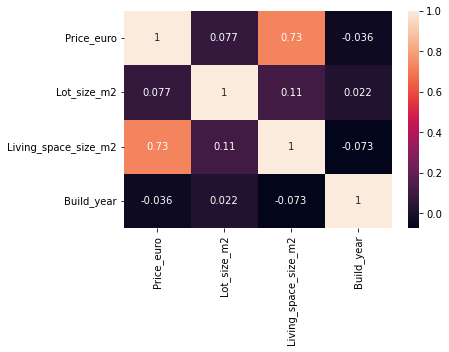

In [94]:
# Check correlation among numerical data
sns.heatmap(raw_data.corr(), annot=True)
plt.show

In [43]:
# Dealing with missing value
print(raw_data.isna().sum())
threshold =len(raw_data)*0.055
print("threshold", threshold)
cols_to_drop = raw_data.columns[raw_data.isna().sum() <= threshold] &  raw_data.columns[raw_data.isna().sum()>0]
print(cols_to_drop)

Address                   0
City                      0
Price_euro               13
Lot_size_m2               0
Living_space_size_m2      0
Build_year              104
Build_type                0
House_type                0
Roof                      0
Rooms                     0
Toilet                    0
Floors                    0
Energy_label              0
Position                304
Garden                   58
dtype: int64
threshold 305.47
Index(['Price_euro', 'Build_year', 'Position', 'Garden'], dtype='object')


C:\Users\camila\AppData\Local\Temp\ipykernel_5988\1578059923.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  cols_to_drop = raw_data.columns[raw_data.isna().sum() <= threshold] &  raw_data.columns[raw_data.isna().sum()>0]


In [226]:
# As all columns with missing value has percentage less than 0.055 threshold, we delete them all.
raw_data = raw_data.dropna(subset=['Price_euro','Build_year','Position','Garden'], axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5085 entries, 1 to 5554
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Address               5085 non-null   object  
 1   City                  5085 non-null   object  
 2   Price_euro            5085 non-null   float64 
 3   Lot_size_m2           5085 non-null   float64 
 4   Living_space_size_m2  5085 non-null   int64   
 5   Build_year            5085 non-null   Int64   
 6   Build_type            5085 non-null   category
 7   House_type            5085 non-null   category
 8   Roof                  5085 non-null   category
 9   Rooms                 5085 non-null   category
 10  Toilet                5085 non-null   category
 11  Floors                5085 non-null   category
 12  Energy_label          5085 non-null   category
 13  Position              5085 non-null   category
 14  Garden                5085 non-null   category
dtypes: I

In [203]:
geolocator = Nominatim(user_agent="student thesis project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [204]:
test_sample = raw_data.iloc[0:5,:].copy()
test_sample.head()

Address         City  Price_euro  Lot_size_m2  \
1  Julianastraat 19  Waddinxveen    425000.0        181.0   
2    Kuipersgilde 3       Houten    575000.0        198.0   
3       De Kamp 1 A    Pannerden    259500.0        231.0   
4    Wildrijklaan 8   Sassenheim   1050000.0        423.0   
5             Tol 4    Oudewater    445000.0        127.0   

   Living_space_size_m2  Build_year      Build_type  \
1                   109        1935  Bestaande bouw   
2                   138        1986  Bestaande bouw   
3                    92        1989  Bestaande bouw   
4                   210        2000  Bestaande bouw   
5                   126        2016  Bestaande bouw   

                                   House_type  \
1  Herenhuis, geschakelde 2-onder-1-kapwoning   
2        Eengezinswoning, 2-onder-1-kapwoning   
3        Eengezinswoning, 2-onder-1-kapwoning   
4        Eengezinswoning, 2-onder-1-kapwoning   
5               Eengezinswoning, tussenwoning   

                                                Roof  \
1  Schilddak bedekt met bitumineuze dakbedekking ...   
2                         Zadeldak bedekt met pannen   
3                         Zadeldak bedekt met pannen   
4                        Schilddak bedekt met pannen   
5                         Dwarskap bedekt met pannen   

                      Rooms                             Toilet  \
1  4 kamers (3 slaapkamers)       1 badkamer en 1 apart toilet   
2  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   
3  5 kamers (3 slaapkamers)   1 badkamer en 2 aparte toiletten   
4  6 kamers (5 slaapkamers)  2 badkamers en 2 aparte toiletten   
5  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   

                      Floors Energy_label  \
1                3 woonlagen            E   
2                3 woonlagen            B   
3                3 woonlagen            B   
4  4 woonlagen en een kelder            A   
5                3 woonlagen            A   

                                            Position  \
1                     Aan rustige weg en in woonwijk   
2                     Aan rustige weg en in woonwijk   
3                     Aan rustige weg en in woonwijk   
4  Aan rustige weg, aan water, beschutte ligging,...   
5                                        In woonwijk   

                            Garden  
1           Achtertuin en voortuin  
2                       Achtertuin  
3  Achtertuin, voortuin en zijtuin  
4  Achtertuin, voortuin en zijtuin  
5           Achtertuin en voortuin

In [205]:
def get_postal_code(index, row):
    try:
        full_address = f"{row['Address']}, {row['City']}"
        location = geocode(full_address)
        print(f"Index: {index}, Location: {location}")
        return location
    except Exception as e:
        print(f"Error geocoding {full_address} at index {index}: {str(e)}")
        return None


In [208]:
# Test_sample, delete at the end
# Getting postcode by address and city
test_sample['Geocoded_Location'] = test_sample.apply(lambda row: get_postal_code(row.name, row), axis=1)
test_sample.head()

Index: 1, Location: 19, Julianastraat, Centrum, Waddinxveen, Zuid-Holland, Nederland, 2741 HJ, Nederland
Index: 2, Location: 3, Kuipersgilde, Houten, Utrecht, Nederland, 3994 CD, Nederland
Index: 3, Location: 1a, De Kamp, Pannerden, Zevenaar, Gelderland, Nederland, 6911 BV, Nederland
Index: 4, Location: 8, Wildrijklaan, Sassenheim, Teylingen, Zuid-Holland, Nederland, 2171 RG, Nederland
Index: 5, Location: 4, Tol, Oudewater, Utrecht, Nederland, 3421 KV, Nederland


Address         City  Price_euro  Lot_size_m2  \
1  Julianastraat 19  Waddinxveen    425000.0        181.0   
2    Kuipersgilde 3       Houten    575000.0        198.0   
3       De Kamp 1 A    Pannerden    259500.0        231.0   
4    Wildrijklaan 8   Sassenheim   1050000.0        423.0   
5             Tol 4    Oudewater    445000.0        127.0   

   Living_space_size_m2  Build_year      Build_type  \
1                   109        1935  Bestaande bouw   
2                   138        1986  Bestaande bouw   
3                    92        1989  Bestaande bouw   
4                   210        2000  Bestaande bouw   
5                   126        2016  Bestaande bouw   

                                   House_type  \
1  Herenhuis, geschakelde 2-onder-1-kapwoning   
2        Eengezinswoning, 2-onder-1-kapwoning   
3        Eengezinswoning, 2-onder-1-kapwoning   
4        Eengezinswoning, 2-onder-1-kapwoning   
5               Eengezinswoning, tussenwoning   

                                                Roof  \
1  Schilddak bedekt met bitumineuze dakbedekking ...   
2                         Zadeldak bedekt met pannen   
3                         Zadeldak bedekt met pannen   
4                        Schilddak bedekt met pannen   
5                         Dwarskap bedekt met pannen   

                      Rooms                             Toilet  \
1  4 kamers (3 slaapkamers)       1 badkamer en 1 apart toilet   
2  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   
3  5 kamers (3 slaapkamers)   1 badkamer en 2 aparte toiletten   
4  6 kamers (5 slaapkamers)  2 badkamers en 2 aparte toiletten   
5  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   

                      Floors Energy_label  \
1                3 woonlagen            E   
2                3 woonlagen            B   
3                3 woonlagen            B   
4  4 woonlagen en een kelder            A   
5                3 woonlagen            A   

                                            Position  \
1                     Aan rustige weg en in woonwijk   
2                     Aan rustige weg en in woonwijk   
3                     Aan rustige weg en in woonwijk   
4  Aan rustige weg, aan water, beschutte ligging,...   
5                                        In woonwijk   

                            Garden  \
1           Achtertuin en voortuin   
2                       Achtertuin   
3  Achtertuin, voortuin en zijtuin   
4  Achtertuin, voortuin en zijtuin   
5           Achtertuin en voortuin   

                                   Geocoded_Location  
1  (19, Julianastraat, Centrum, Waddinxveen, Zuid...  
2  (3, Kuipersgilde, Houten, Utrecht, Nederland, ...  
3  (1a, De Kamp, Pannerden, Zevenaar, Gelderland,...  
4  (8, Wildrijklaan, Sassenheim, Teylingen, Zuid-...  
5  (4, Tol, Oudewater, Utrecht, Nederland, 3421 K...

In [187]:
# Getting postcode by address and city
raw_data['Geocoded_Location'] = raw_data.apply(lambda row: get_postal_code(row.name, row), axis=1)

Index: 1, Location: 19, Julianastraat, Centrum, Waddinxveen, Zuid-Holland, Nederland, 2741 HJ, Nederland
Index: 2, Location: 3, Kuipersgilde, Houten, Utrecht, Nederland, 3994 CD, Nederland
Index: 3, Location: 1a, De Kamp, Pannerden, Zevenaar, Gelderland, Nederland, 6911 BV, Nederland
Index: 4, Location: 8, Wildrijklaan, Sassenheim, Teylingen, Zuid-Holland, Nederland, 2171 RG, Nederland
Index: 5, Location: 4, Tol, Oudewater, Utrecht, Nederland, 3421 KV, Nederland
Index: 6, Location: 698, Furkabaan, Lunetten, Utrecht, Nederland, 3524 ZM, Nederland
Index: 7, Location: 71, Abeelstraat, Dubbeldam, Dordrecht, Zuid-Holland, Nederland, 3329 AB, Nederland
Index: 8, Location: 8, Overegge, Zuidveen, Steenwijkerland, Overijssel, Nederland, 8343 XB, Nederland
Index: 9, Location: 59, Gaasterland, Westwijk, Amstelveen, Noord-Holland, Nederland, 1187 KB, Nederland
Index: 10, Location: 53, Oostopgaande, Nieuwlande Coevorden, Nieuwlande, Hoogeveen, Drenthe, Nederland, 7918 TC, Nederland
Index: 11, Locat

In [ ]:
# Save the raw_data with post code information
raw_data.to_csv('C:/Users/camila/Desktop/clean_data.csv', index=False)

# 2. Start the continue project with new dataset (load clean_data, data cleaning for the dataset with postcode) 


In [10]:
# 2.1 extract only postcode from full address
clean_data= pd.read_csv('clean_data_.csv')

In [11]:
# Extract postcode which is representitive for geographic information
clean_data['Postcode'] = clean_data['Geocoded_Location'].str[-19:-14]
clean_data.head()

Address         City  Price_euro  Lot_size_m2  \
0  Julianastraat 19  Waddinxveen      425000        181.0   
1    Kuipersgilde 3       Houten      575000        198.0   
2       De Kamp 1 A    Pannerden      259500        231.0   
3    Wildrijklaan 8   Sassenheim     1050000        423.0   
4             Tol 4    Oudewater      445000        127.0   

   Living_space_size_m2  Build_year      Build_type  \
0                   109        1935  Bestaande bouw   
1                   138        1986  Bestaande bouw   
2                    92        1989  Bestaande bouw   
3                   210        2000  Bestaande bouw   
4                   126        2016  Bestaande bouw   

                                   House_type  \
0  Herenhuis, geschakelde 2-onder-1-kapwoning   
1        Eengezinswoning, 2-onder-1-kapwoning   
2        Eengezinswoning, 2-onder-1-kapwoning   
3        Eengezinswoning, 2-onder-1-kapwoning   
4               Eengezinswoning, tussenwoning   

                                                Roof  \
0  Schilddak bedekt met bitumineuze dakbedekking ...   
1                         Zadeldak bedekt met pannen   
2                         Zadeldak bedekt met pannen   
3                        Schilddak bedekt met pannen   
4                         Dwarskap bedekt met pannen   

                      Rooms                             Toilet  \
0  4 kamers (3 slaapkamers)       1 badkamer en 1 apart toilet   
1  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   
2  5 kamers (3 slaapkamers)   1 badkamer en 2 aparte toiletten   
3  6 kamers (5 slaapkamers)  2 badkamers en 2 aparte toiletten   
4  5 kamers (4 slaapkamers)       1 badkamer en 1 apart toilet   

                      Floors Energy_label  \
0                3 woonlagen            E   
1                3 woonlagen            B   
2                3 woonlagen            B   
3  4 woonlagen en een kelder            A   
4                3 woonlagen            A   

                                            Position  \
0                     Aan rustige weg en in woonwijk   
1                     Aan rustige weg en in woonwijk   
2                     Aan rustige weg en in woonwijk   
3  Aan rustige weg, aan water, beschutte ligging,...   
4                                        In woonwijk   

                            Garden  \
0           Achtertuin en voortuin   
1                       Achtertuin   
2  Achtertuin, voortuin en zijtuin   
3  Achtertuin, voortuin en zijtuin   
4           Achtertuin en voortuin   

                                   Geocoded_Location Postcode  
0  19, Julianastraat, Centrum, Waddinxveen, Zuid-...     2741  
1  3, Kuipersgilde, Houten, Utrecht, Nederland, 3...     3994  
2  1a, De Kamp, Pannerden, Zevenaar, Gelderland, ...     6911  
3  8, Wildrijklaan, Sassenheim, Teylingen, Zuid-H...     2171  
4  4, Tol, Oudewater, Utrecht, Nederland, 3421 KV...     3421

In [12]:
# 2.2 Drop useless columns
clean_data = clean_data.drop(['Geocoded_Location','Address',"Build_type","City"], axis=1)
clean_data['Postcode'] = clean_data['Postcode'].str.replace(',', '')

In [13]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5085 entries, 0 to 5084
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price_euro            5085 non-null   int64  
 1   Lot_size_m2           5085 non-null   float64
 2   Living_space_size_m2  5085 non-null   int64  
 3   Build_year            5085 non-null   int64  
 4   House_type            5085 non-null   object 
 5   Roof                  5085 non-null   object 
 6   Rooms                 5085 non-null   object 
 7   Toilet                5085 non-null   object 
 8   Floors                5085 non-null   object 
 9   Energy_label          5085 non-null   object 
 10  Position              5085 non-null   object 
 11  Garden                5085 non-null   object 
 12  Postcode              5047 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 516.6+ KB


In [14]:
#2.3 initial convert of data type  
clean_data["Price_euro"] = clean_data["Price_euro"].astype(float) 
clean_data["Living_space_size_m2"] = clean_data["Living_space_size_m2"].astype(float)

In [15]:
# 2.4 Drop missing value and reset index
clean_data = clean_data.dropna(subset='Postcode', axis=0)
clean_data.reset_index(drop=True, inplace=True)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5047 entries, 0 to 5046
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price_euro            5047 non-null   float64
 1   Lot_size_m2           5047 non-null   float64
 2   Living_space_size_m2  5047 non-null   float64
 3   Build_year            5047 non-null   int64  
 4   House_type            5047 non-null   object 
 5   Roof                  5047 non-null   object 
 6   Rooms                 5047 non-null   object 
 7   Toilet                5047 non-null   object 
 8   Floors                5047 non-null   object 
 9   Energy_label          5047 non-null   object 
 10  Position              5047 non-null   object 
 11  Garden                5047 non-null   object 
 12  Postcode              5047 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 512.7+ KB


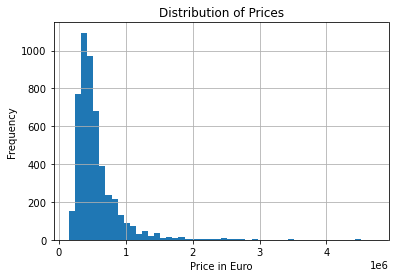

In [16]:
# 2.5 Initiate EDA
# Histogram
clean_data['Price_euro'].hist(bins=50)
plt.title('Distribution of Prices')
plt.xlabel('Price in Euro')
plt.ylabel('Frequency')
plt.show()

# 3. Obtain datasets for group of income of only middle and low class

### 3.1 Restrict housing price for middle and low class according to income of 2022, and mortage calculator of 2024

In [17]:
low_middle_data = clean_data[clean_data["Price_euro"] <= 532924]

In [18]:
print('DataFrame shape after filtering on price for low-middle class: ',low_middle_data.shape)

DataFrame shape after filtering on price for low-middle class:  (3126, 13)


### 3.2 Include data to normalize distribution

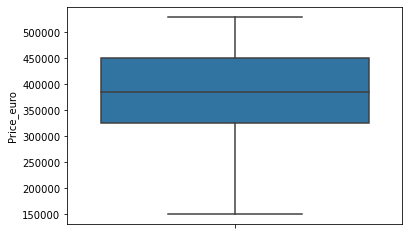

In [19]:
sns.boxplot(data = low_middle_data, y = "Price_euro" )
plt.show()

In [20]:
# 75th percentile
seventy_fifth = low_middle_data["Price_euro"].quantile(0.75)
# 25th percentile
twenty_fifth = low_middle_data["Price_euro"].quantile(0.25)
price_iqr = seventy_fifth - twenty_fifth
print(price_iqr)

125000.0


In [21]:
# upper threshold
upper = seventy_fifth + (1.5 * price_iqr)
lower = twenty_fifth - (1.5 * price_iqr)
print(upper, lower)

637500.0 137500.0


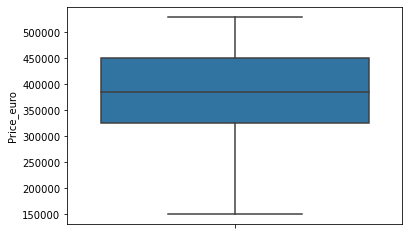

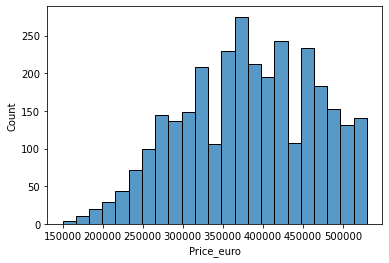

In [22]:
final_data = low_middle_data[(low_middle_data["Price_euro"] >= lower)] 
sns.boxplot(data = final_data, y = "Price_euro" )
plt.show()
sns.histplot(data = final_data, x = "Price_euro" )
plt.show()

In [23]:
print('DataFrame shape after filtering on price: ',final_data.shape)

DataFrame shape after filtering on price:  (3126, 13)


### 3.3 Include data of price of upper restriction to normal distribution

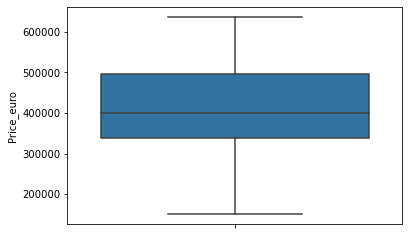

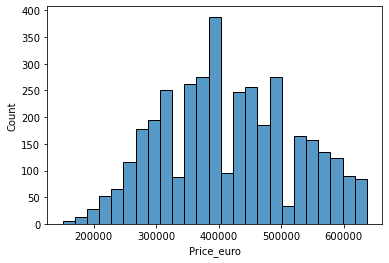

In [24]:
# Confirm the final dataset
low_middle_data = clean_data[clean_data["Price_euro"] <= upper]
final_data = low_middle_data[(low_middle_data["Price_euro"] >= lower)] 
sns.boxplot(data = final_data, y = "Price_euro" )
plt.show()
sns.histplot(data = final_data, x = "Price_euro" )
plt.show()

In [25]:
print('DataFrame shape after filtering on price: ',final_data.shape)

DataFrame shape after filtering on price:  (3766, 13)


# 4. EDA and Feature engineering

In [26]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3766 entries, 0 to 5046
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price_euro            3766 non-null   float64
 1   Lot_size_m2           3766 non-null   float64
 2   Living_space_size_m2  3766 non-null   float64
 3   Build_year            3766 non-null   int64  
 4   House_type            3766 non-null   object 
 5   Roof                  3766 non-null   object 
 6   Rooms                 3766 non-null   object 
 7   Toilet                3766 non-null   object 
 8   Floors                3766 non-null   object 
 9   Energy_label          3766 non-null   object 
 10  Position              3766 non-null   object 
 11  Garden                3766 non-null   object 
 12  Postcode              3766 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 411.9+ KB


In [27]:
print(final_data.describe())

          Price_euro  Lot_size_m2  Living_space_size_m2   Build_year
count    3766.000000  3766.000000           3766.000000  3766.000000
mean   415040.369623   235.710733            124.921136  1970.803505
std    105817.998124   158.701777             32.052545    34.623187
min    150000.000000     1.008000             53.000000  1590.000000
25%    339000.000000   138.000000            105.000000  1959.000000
50%    400000.000000   184.000000            120.000000  1976.000000
75%    495000.000000   282.000000            140.000000  1993.000000
max    637000.000000   993.000000            503.000000  2022.000000


In [28]:
final_data.nunique()

Price_euro               292
Lot_size_m2              702
Living_space_size_m2     199
Build_year               160
House_type                78
Roof                      67
Rooms                     49
Toilet                    13
Floors                    27
Energy_label              11
Position                 271
Garden                    41
Postcode                1565
dtype: int64

## 4.1 Dealing with numerical value

In [29]:
# 4.1.1 Convert "build year" to age, which is more directly correlated with price
final_data['House_age'] = 2022 - final_data['Build_year']
final_data = final_data.drop('Build_year', axis=1 )

In [30]:
# 4.1.2 "Rooms" = numerical data, separate the column
final_data['rooms'] = final_data["Rooms"].str.extract('(\d+) kamers').fillna(0).astype(int)
final_data['Bedrooms'] = final_data["Rooms"].str.extract('(\d+) slaapkamers').fillna(0).astype(int)
final_data['Other_rooms'] = final_data['rooms'] - final_data['Bedrooms']
final_data=final_data.drop("Rooms",axis=1)
final_data=final_data.drop("rooms",axis=1)

In [31]:
#4.1.3 "Toilet" = numerical data, seperate the column
print(final_data["Toilet"].value_counts())
# Extracting the number of bathrooms and toilets
final_data['Bathrooms'] = final_data["Toilet"].str.extract('(\d+) badkamer').fillna(0).astype(int)
final_data['Apart_toilet'] = final_data["Toilet"].str.extract('(\d+) apart').fillna(0).astype(int)
final_data=final_data.drop("Toilet",axis=1)

1 badkamer en 1 apart toilet         2886
1 badkamer en 2 aparte toiletten      331
2 badkamers en 1 apart toilet         227
1 badkamer                            217
2 badkamers                            47
2 badkamers en 2 aparte toiletten      39
3 badkamers en 1 apart toilet           6
1 badkamer en 3 aparte toiletten        6
3 badkamers                             2
2 badkamers en 3 aparte toiletten       2
3 badkamers en 3 aparte toiletten       1
4 badkamers en 3 aparte toiletten       1
4 badkamers en 1 apart toilet           1
Name: Toilet, dtype: int64


In [32]:
# 4.1.4 Floor
# Function to extract the number of levels from the description
def count_levels(description):
    parts = description.split()
    for part in parts:
        if 'woonlagen' in part:
            index = parts.index(part)
            return int(parts[index-1])
    return 0

# Apply the function
final_data['Floor_count'] = final_data['Floors'].apply(count_levels)
final_data.rename(columns={'Floors': 'Floor_types'}, inplace=True)

In [33]:
numeric_cols = ['Lot_size_m2', 'Living_space_size_m2', 'House_age', 'Bedrooms','Other_rooms',  'Bathrooms','Apart_toilet', 'Floor_count' ]


array([[<AxesSubplot:title={'center':'Price_euro'}>,
        <AxesSubplot:title={'center':'Lot_size_m2'}>,
        <AxesSubplot:title={'center':'Living_space_size_m2'}>],
       [<AxesSubplot:title={'center':'House_age'}>,
        <AxesSubplot:title={'center':'Bedrooms'}>,
        <AxesSubplot:title={'center':'Other_rooms'}>],
       [<AxesSubplot:title={'center':'Bathrooms'}>,
        <AxesSubplot:title={'center':'Apart_toilet'}>,
        <AxesSubplot:title={'center':'Floor_count'}>]], dtype=object)

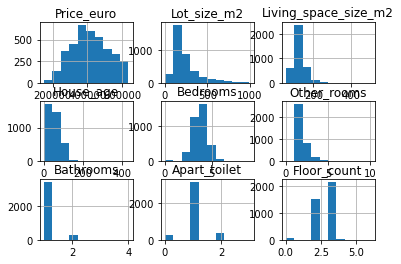

In [34]:
final_data.hist()

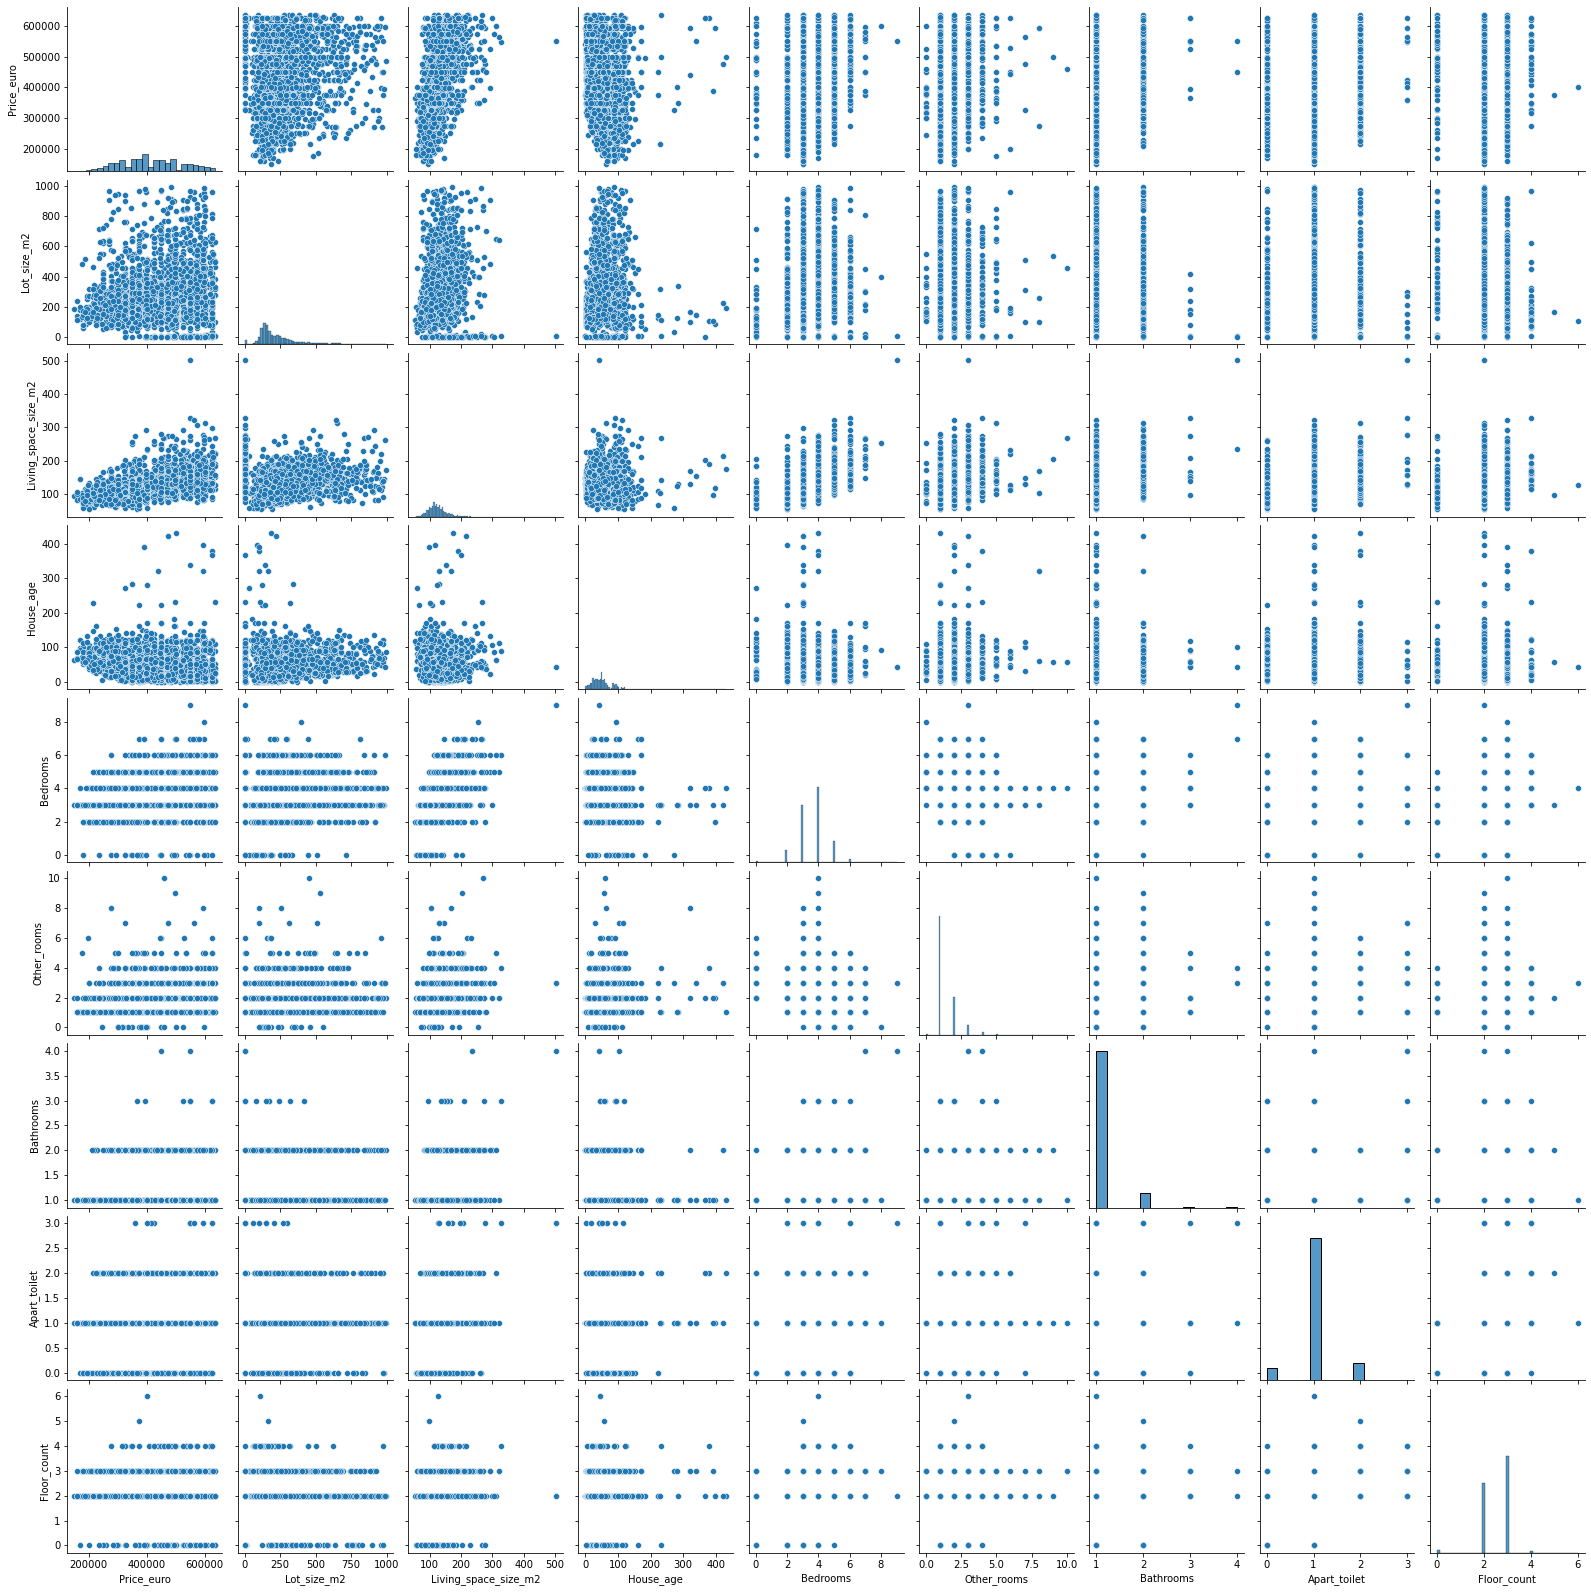

In [35]:
sns.pairplot(final_data)

<AxesSubplot:>

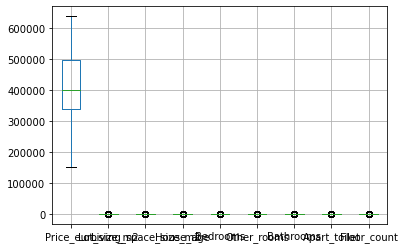

In [36]:
final_data.boxplot()

In [37]:
final_data_withoutprice = final_data.copy()

In [38]:
final_data_withoutprice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3766 entries, 0 to 5046
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price_euro            3766 non-null   float64
 1   Lot_size_m2           3766 non-null   float64
 2   Living_space_size_m2  3766 non-null   float64
 3   House_type            3766 non-null   object 
 4   Roof                  3766 non-null   object 
 5   Floor_types           3766 non-null   object 
 6   Energy_label          3766 non-null   object 
 7   Position              3766 non-null   object 
 8   Garden                3766 non-null   object 
 9   Postcode              3766 non-null   object 
 10  House_age             3766 non-null   int64  
 11  Bedrooms              3766 non-null   int32  
 12  Other_rooms           3766 non-null   int32  
 13  Bathrooms             3766 non-null   int32  
 14  Apart_toilet          3766 non-null   int32  
 15  Floor_count          

<AxesSubplot:>

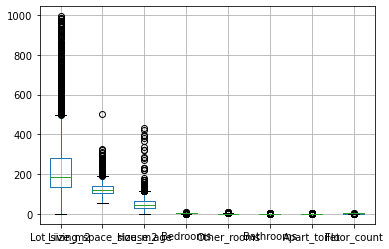

In [39]:
final_data_withoutprice=final_data_withoutprice.drop(['Price_euro'], axis=1)
final_data_withoutprice.boxplot()

### remove outliers

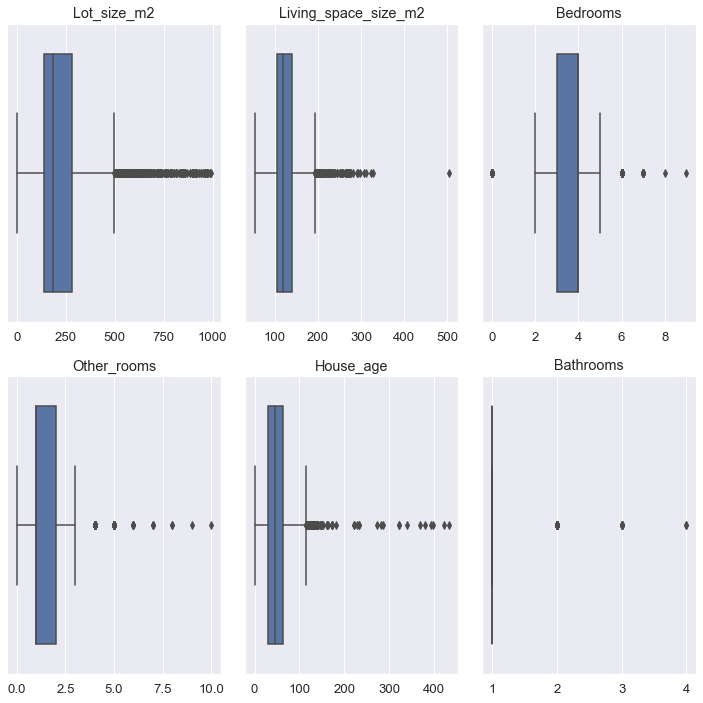

In [40]:
#Dealing with numerical outliers
def plot_boxplots(data, columns):
    sns.set(style='darkgrid', font_scale=1.2)
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
    axs = axs.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(x=data[col], ax=axs[i])
        axs[i].set_title(col)
        axs[i].set_xlabel('')
    fig.tight_layout()
    plt.show()
numerical_plot_1 = ['Lot_size_m2', 'Living_space_size_m2', 'Bedrooms','Other_rooms', 'House_age', 'Bathrooms']
numerical_plot_2 = ['Apart_toilet','Floor_count']
plot_boxplots(final_data, columns =numerical_plot_1)

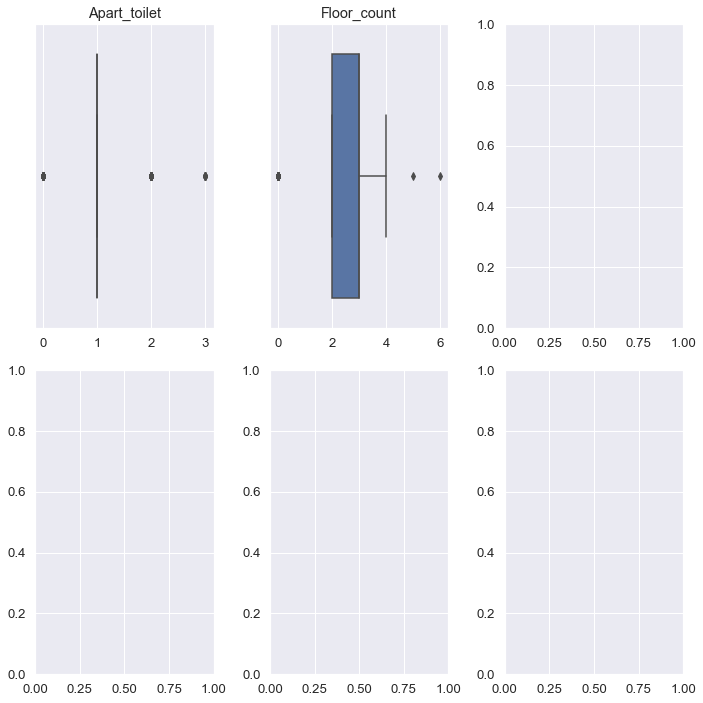

In [41]:
plot_boxplots(final_data, columns =numerical_plot_2)

In [42]:
# Define the number of standard deviations
std_devs = 3

# Calculate the mean and standard deviation
mean_lss = final_data['Living_space_size_m2'].mean()
std_lss = final_data['Living_space_size_m2'].std()

mean_ls = final_data['Lot_size_m2'].mean()
std_ls = final_data['Lot_size_m2'].std()

# Identify outliers
outliers_lss = (final_data['Living_space_size_m2'] < (mean_lss - std_devs * std_lss)) | \
               (final_data['Living_space_size_m2'] > (mean_lss + std_devs * std_lss))

outliers_ls = (final_data['Lot_size_m2'] < (mean_ls - std_devs * std_ls)) | \
              (final_data['Lot_size_m2'] > (mean_ls + std_devs * std_ls))

# Combine the outlier masks with an OR operation
outliers = outliers_lss | outliers_ls

# Remove outliers from X_train
final_data_filtered = final_data[~outliers]

print(f"Original final_data shape: {final_data.shape}")


# check how many outliers were removed
print(f"Number of outliers removed: {final_data.shape[0] - final_data_filtered.shape[0]}")


Original final_data shape: (3766, 16)
Number of outliers removed: 134


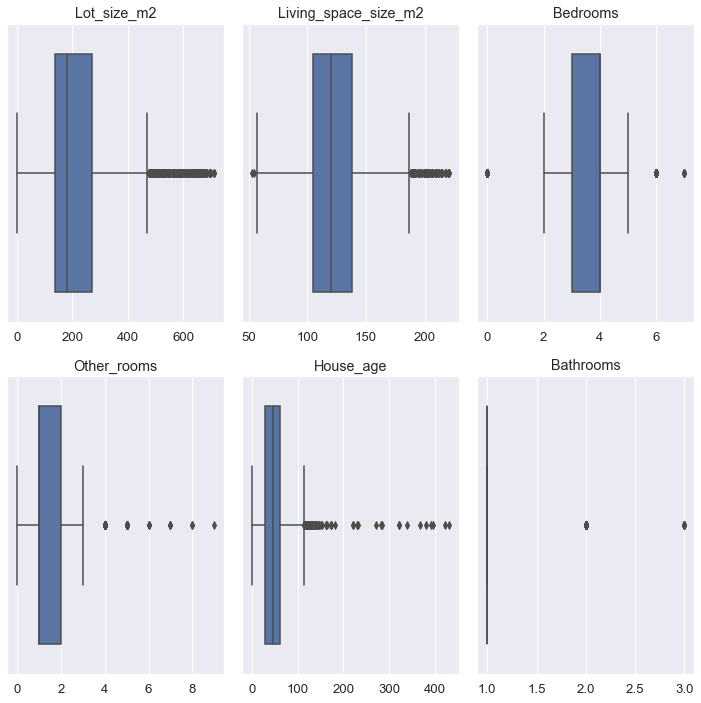

In [43]:
plot_boxplots(final_data_filtered, columns =numerical_plot_1)

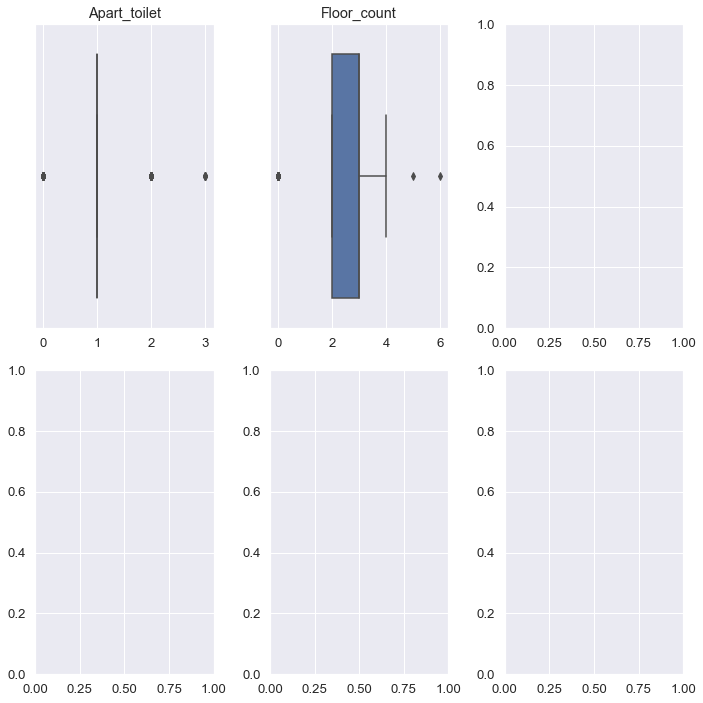

In [44]:
plot_boxplots(final_data_filtered, columns =numerical_plot_2)

In [45]:
final_data_filtered.describe()

Price_euro  Lot_size_m2  Living_space_size_m2    House_age  \
count    3632.000000  3632.000000           3632.000000  3632.000000   
mean   412056.589207   220.732106            122.588381    50.446586   
std    104775.585292   126.258218             27.156906    34.374866   
min    150000.000000     1.008000             53.000000     0.000000   
25%    335000.000000   137.000000            105.000000    28.000000   
50%    400000.000000   181.000000            120.000000    46.000000   
75%    490000.000000   270.250000            138.000000    62.000000   
max    637000.000000   711.000000            221.000000   432.000000   

          Bedrooms  Other_rooms    Bathrooms  Apart_toilet  Floor_count  
count  3632.000000  3632.000000  3632.000000   3632.000000  3632.000000  
mean      3.644548     1.380507     1.080947      1.030837     2.575716  
std       0.917427     0.741822     0.279769      0.416060     0.591684  
min       0.000000     0.000000     1.000000      0.000000     0.000000  
25%       3.000000     1.000000     1.000000      1.000000     2.000000  
50%       4.000000     1.000000     1.000000      1.000000     3.000000  
75%       4.000000     2.000000     1.000000      1.000000     3.000000  
max       7.000000     9.000000     3.000000      3.000000     6.000000

array([[<AxesSubplot:title={'center':'Price_euro'}>,
        <AxesSubplot:title={'center':'Lot_size_m2'}>,
        <AxesSubplot:title={'center':'Living_space_size_m2'}>],
       [<AxesSubplot:title={'center':'House_age'}>,
        <AxesSubplot:title={'center':'Bedrooms'}>,
        <AxesSubplot:title={'center':'Other_rooms'}>],
       [<AxesSubplot:title={'center':'Bathrooms'}>,
        <AxesSubplot:title={'center':'Apart_toilet'}>,
        <AxesSubplot:title={'center':'Floor_count'}>]], dtype=object)

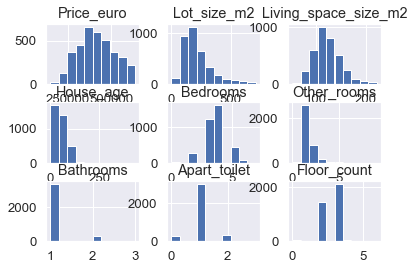

In [46]:
final_data_filtered.hist()

### check correlation

Price_euro              1.000000
Living_space_size_m2    0.569118
Lot_size_m2             0.221361
Bedrooms                0.213503
Bathrooms               0.146308
Apart_toilet            0.142093
Other_rooms             0.098298
Floor_count             0.089044
House_age              -0.137801
Name: Price_euro, dtype: float64


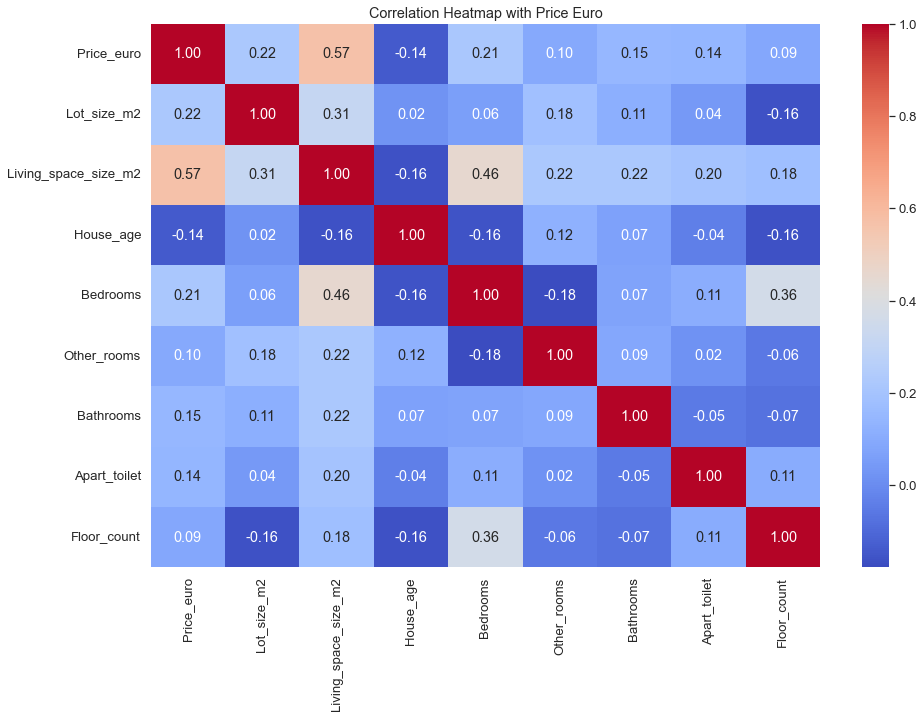

In [47]:
# Plot the correlation heatmap
correlations_1 = final_data_filtered.corr()
print(correlations_1['Price_euro'].sort_values(ascending=False))
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.heatmap(correlations_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap with Price Euro')
plt.show()


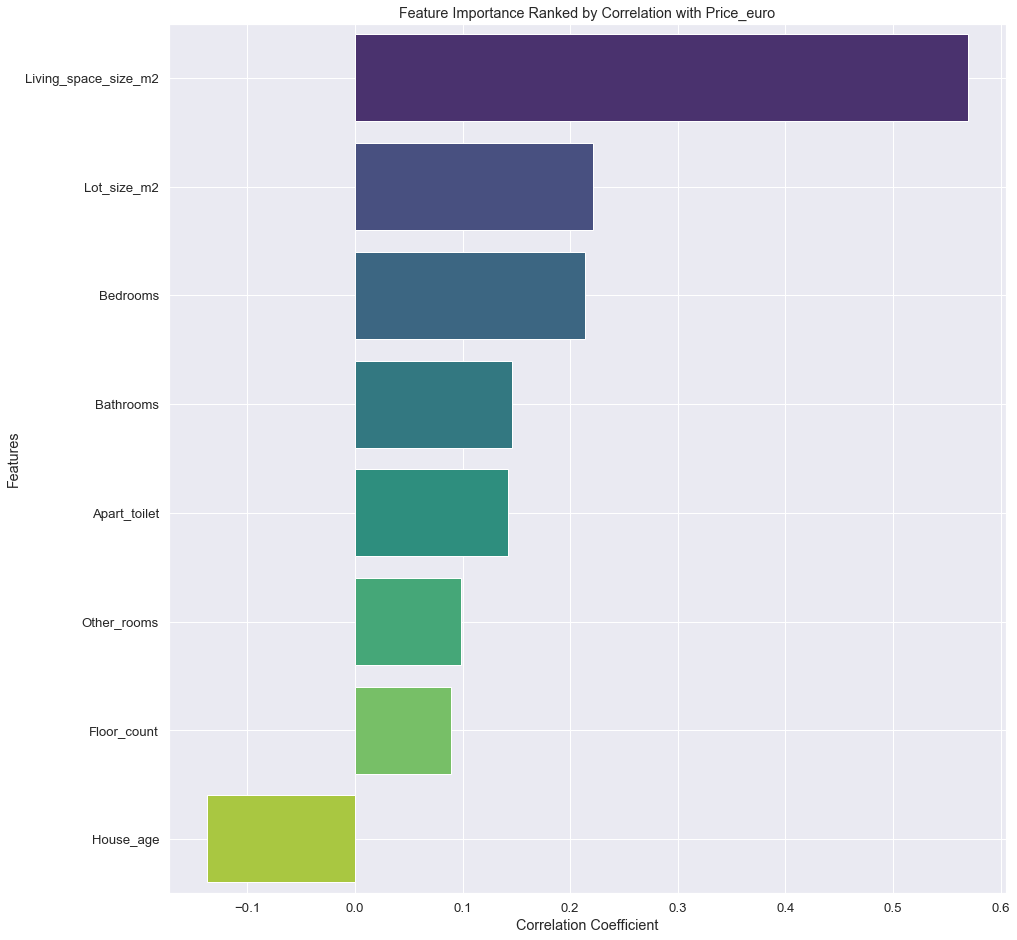

In [48]:
# Calculate the correlation with the target variable
correlation_bar1 = final_data_filtered.corr()['Price_euro'].sort_values(ascending=False)

# Create a DataFrame for easier plotting
correlation_df1 = pd.DataFrame(correlation_bar1).reset_index()
correlation_df1.columns = ['Feature', 'Correlation']

# Removing the target variable correlation with itself for plotting
correlation_df1 = correlation_df1[correlation_df1.Feature != 'Price_euro']

# Plotting
plt.figure(figsize=(15, 16))  
sns.barplot(x='Correlation', y='Feature', data=correlation_df1, palette="viridis")
plt.title('Feature Importance Ranked by Correlation with Price_euro')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()


In [49]:
final_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 5046
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price_euro            3632 non-null   float64
 1   Lot_size_m2           3632 non-null   float64
 2   Living_space_size_m2  3632 non-null   float64
 3   House_type            3632 non-null   object 
 4   Roof                  3632 non-null   object 
 5   Floor_types           3632 non-null   object 
 6   Energy_label          3632 non-null   object 
 7   Position              3632 non-null   object 
 8   Garden                3632 non-null   object 
 9   Postcode              3632 non-null   object 
 10  House_age             3632 non-null   int64  
 11  Bedrooms              3632 non-null   int32  
 12  Other_rooms           3632 non-null   int32  
 13  Bathrooms             3632 non-null   int32  
 14  Apart_toilet          3632 non-null   int32  
 15  Floor_count          

In [50]:
final_data_filtered2 = final_data_filtered.copy()
final_data_filtered2['Postcode'] = pd.to_numeric(final_data_filtered2['Postcode'], errors='coerce')

final_data_filtered2.dropna(subset=['Postcode'], inplace=True)

final_data_filtered2['Postcode_reduced'] = (final_data_filtered2['Postcode'] // 1000) * 1000
final_data_filtered2['Postcode_reduced'] = final_data_filtered2['Postcode_reduced'].astype('int')
final_data_filtered2['Postcode_reduced'] = final_data_filtered2['Postcode_reduced'].astype('category')

final_data_filtered2.drop(['Postcode'], axis=1, inplace=True)


In [51]:
final_data_filtered2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3631 entries, 0 to 5046
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Price_euro            3631 non-null   float64 
 1   Lot_size_m2           3631 non-null   float64 
 2   Living_space_size_m2  3631 non-null   float64 
 3   House_type            3631 non-null   object  
 4   Roof                  3631 non-null   object  
 5   Floor_types           3631 non-null   object  
 6   Energy_label          3631 non-null   object  
 7   Position              3631 non-null   object  
 8   Garden                3631 non-null   object  
 9   House_age             3631 non-null   int64   
 10  Bedrooms              3631 non-null   int32   
 11  Other_rooms           3631 non-null   int32   
 12  Bathrooms             3631 non-null   int32   
 13  Apart_toilet          3631 non-null   int32   
 14  Floor_count           3631 non-null   int64   
 15  Post

# 4.2 split the data

In [52]:
X = final_data_filtered2.drop('Price_euro', axis=1)  
y = final_data_filtered2['Price_euro'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train.head()

Lot_size_m2  Living_space_size_m2                           House_type  \
4974         1.01                 160.0  Eengezinswoning, vrijstaande woning   
4973       309.00                 185.0          Eengezinswoning, eindwoning   
3023       154.00                  77.0          Eengezinswoning, hoekwoning   
1678       161.00                 134.0        Eengezinswoning, tussenwoning   
695        135.00                 105.0        Eengezinswoning, tussenwoning   

                                              Roof  \
4974                    Zadeldak bedekt met pannen   
4973                    Plat dak bedekt met overig   
3023  Plat dak bedekt met bitumineuze dakbedekking   
1678                    Zadeldak bedekt met pannen   
695                     Zadeldak bedekt met pannen   

                      Floor_types Energy_label  \
4974  2 woonlagen en een vliering            B   
4973                  3 woonlagen            A   
3023                  2 woonlagen            G   
1678                  3 woonlagen            C   
695                   3 woonlagen            C   

                                              Position  \
4974  Landelijk gelegen, open ligging en vrij uitzicht   
4973                                       In woonwijk   
3023              Aan water, in centrum en in woonwijk   
1678                                       In woonwijk   
695                     Aan rustige weg en in woonwijk   

                               Garden  House_age  Bedrooms  Other_rooms  \
4974  Achtertuin, voortuin en zijtuin         52         6            2   
4973                       Achtertuin         16         0            3   
3023  Achtertuin, voortuin en zijtuin        102         3            1   
1678           Achtertuin en voortuin         47         4            1   
695            Achtertuin en voortuin         87         4            1   

      Bathrooms  Apart_toilet  Floor_count Postcode_reduced  
4974          1             1            2             6000  
4973          2             1            3             4000  
3023          1             0            2             1000  
1678          1             1            3             4000  
695           1             0            3             5000

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2904 entries, 4974 to 4252
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Lot_size_m2           2904 non-null   float64 
 1   Living_space_size_m2  2904 non-null   float64 
 2   House_type            2904 non-null   object  
 3   Roof                  2904 non-null   object  
 4   Floor_types           2904 non-null   object  
 5   Energy_label          2904 non-null   object  
 6   Position              2904 non-null   object  
 7   Garden                2904 non-null   object  
 8   House_age             2904 non-null   int64   
 9   Bedrooms              2904 non-null   int32   
 10  Other_rooms           2904 non-null   int32   
 11  Bathrooms             2904 non-null   int32   
 12  Apart_toilet          2904 non-null   int32   
 13  Floor_count           2904 non-null   int64   
 14  Postcode_reduced      2904 non-null   category
dtypes

In [55]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 2904 entries, 4974 to 4252
Series name: Price_euro
Non-Null Count  Dtype  
--------------  -----  
2904 non-null   float64
dtypes: float64(1)
memory usage: 45.4 KB


In [56]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 838 to 1152
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Lot_size_m2           727 non-null    float64 
 1   Living_space_size_m2  727 non-null    float64 
 2   House_type            727 non-null    object  
 3   Roof                  727 non-null    object  
 4   Floor_types           727 non-null    object  
 5   Energy_label          727 non-null    object  
 6   Position              727 non-null    object  
 7   Garden                727 non-null    object  
 8   House_age             727 non-null    int64   
 9   Bedrooms              727 non-null    int32   
 10  Other_rooms           727 non-null    int32   
 11  Bathrooms             727 non-null    int32   
 12  Apart_toilet          727 non-null    int32   
 13  Floor_count           727 non-null    int64   
 14  Postcode_reduced      727 non-null    category
dtypes: 

In [57]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 727 entries, 838 to 1152
Series name: Price_euro
Non-Null Count  Dtype  
--------------  -----  
727 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


## 4.3 dealing with categorical value

In [58]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2904, 15)
(2904,)
(727, 15)
(727,)


In [59]:
# 4.2.1 "Garden" can convert to numerical data
print(X_train["Garden"].value_counts())

Achtertuin en voortuin                                       1654
Achtertuin                                                    445
Achtertuin, voortuin en zijtuin                               414
Tuin rondom                                                   131
Achtertuin, voortuin en zonneterras                            46
Achtertuin, voortuin, zijtuin en zonneterras                   31
Achtertuin en zijtuin                                          28
Patio/atrium                                                   23
Voortuin en zijtuin                                            21
Achtertuin, tuin rondom, voortuin en zijtuin                   15
Voortuin                                                       14
Zonneterras                                                    14
Achtertuin en zonneterras                                       9
Zijtuin                                                         6
Plaats                                                          6
Patio/atri

In [60]:
# Initialize vectorizer
dutch_stop_words = stopwords.words('dutch')
vectorizer_garden = CountVectorizer(stop_words=dutch_stop_words, binary=True)


def process_garden_features(df, vectorizer, fit=False):
    df["Garden"] = df["Garden"].str.replace('[^a-zA-Z]', " ").str.lower()
    
    if fit:
        # Fit the vectorizer and transform the data
        garden_matrix = vectorizer.fit_transform(df["Garden"])
    else:
        # Only transform the data
        garden_matrix = vectorizer.transform(df["Garden"])
    
    garden_features = pd.DataFrame(garden_matrix.toarray(), index=df.index,
                                   columns=vectorizer.get_feature_names()).add_prefix('Garden_')
    df = pd.concat([df, garden_features], axis=1)
    if 'Garden_rondom' in df.columns and 'Garden_tuin' in df.columns:
        df['Garden_Tuin_Rondom'] = (df['Garden_rondom'] | df['Garden_tuin']).astype(int)
    return df.drop(['Garden', 'Garden_rondom', 'Garden_tuin', 'Garden_patio'], axis=1, errors='ignore')


In [61]:
# Apply the function to X_train and X_test
X_train = process_garden_features(X_train, vectorizer_garden, fit=True)  
X_test = process_garden_features(X_test, vectorizer_garden)  

C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2389639304.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Garden"] = df["Garden"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2389639304.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Garden"] = df["Garden"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category

In [62]:
# Displaying the head of the transformed train dataset to check
X_train.head()

Lot_size_m2  Living_space_size_m2                           House_type  \
4974         1.01                 160.0  Eengezinswoning, vrijstaande woning   
4973       309.00                 185.0          Eengezinswoning, eindwoning   
3023       154.00                  77.0          Eengezinswoning, hoekwoning   
1678       161.00                 134.0        Eengezinswoning, tussenwoning   
695        135.00                 105.0        Eengezinswoning, tussenwoning   

                                              Roof  \
4974                    Zadeldak bedekt met pannen   
4973                    Plat dak bedekt met overig   
3023  Plat dak bedekt met bitumineuze dakbedekking   
1678                    Zadeldak bedekt met pannen   
695                     Zadeldak bedekt met pannen   

                      Floor_types Energy_label  \
4974  2 woonlagen en een vliering            B   
4973                  3 woonlagen            A   
3023                  2 woonlagen            G   
1678                  3 woonlagen            C   
695                   3 woonlagen            C   

                                              Position  House_age  Bedrooms  \
4974  Landelijk gelegen, open ligging en vrij uitzicht         52         6   
4973                                       In woonwijk         16         0   
3023              Aan water, in centrum en in woonwijk        102         3   
1678                                       In woonwijk         47         4   
695                     Aan rustige weg en in woonwijk         87         4   

      Other_rooms  ...  Apart_toilet  Floor_count  Postcode_reduced  \
4974            2  ...             1            2              6000   
4973            3  ...             1            3              4000   
3023            1  ...             0            2              1000   
1678            1  ...             1            3              4000   
695             1  ...             0            3              5000   

     Garden_achtertuin  Garden_atrium  Garden_plaats  Garden_voortuin  \
4974                 1              0              0                1   
4973                 1              0              0                0   
3023                 1              0              0                1   
1678                 1              0              0                1   
695                  1              0              0                1   

      Garden_zijtuin  Garden_zonneterras  Garden_Tuin_Rondom  
4974               1                   0                   0  
4973               0                   0                   0  
3023               1                   0                   0  
1678               0                   0                   0  
695                0                   0                   0  

[5 rows x 21 columns]

In [63]:
# 4.2.3 "Position" =  categorical data
print(X_train["Position"].value_counts())

Aan rustige weg en in woonwijk                                                       988
In woonwijk                                                                          562
Aan rustige weg, in woonwijk en vrij uitzicht                                        152
Aan rustige weg, beschutte ligging en in woonwijk                                    121
In centrum                                                                            78
                                                                                    ... 
Aan drukke weg, in woonwijk en open ligging                                            1
Aan park, in woonwijk, open ligging en vrij uitzicht                                   1
Aan park, aan rustige weg, aan vaarwater, aan water, in woonwijk en vrij uitzicht      1
Aan rustige weg, in bosrijke omgeving, in centrum en in woonwijk                       1
Aan bosrand, aan park, aan rustige weg, in bosrijke omgeving en in woonwijk            1
Name: Position, Lengt

In [64]:
def process_position_features(df, vectorizer, fit=False):
    df["Position"] = df["Position"].str.replace('[^a-zA-Z]', " ").str.lower()

    stop_words_2 = set(stopwords.words('dutch'))  
    additional_stops = {'en', 'met', 'een', 'de', 'het'}  
    stop_words_2.update(additional_stops)

    if fit:
        position_matrix = vectorizer.fit_transform(df["Position"])
    else:
        position_matrix = vectorizer.transform(df["Position"])
    
    position_features = pd.DataFrame(position_matrix.toarray(), index=df.index,
                                     columns=vectorizer.get_feature_names()).add_prefix('Position_')
    
    df = pd.concat([df, position_features], axis=1)

    combined_features = {
        'Position_vrij_uitzicht': ('Position_vrij', 'Position_uitzicht'),
        'Position_gelegen_landelijk': ('Position_gelegen', 'Position_landelijk'),
        'Position_bosrijke_omgeving': ('Position_bosrijke', 'Position_omgeving')
    }

    for new_col, old_cols in combined_features.items():

        cols_to_combine = [col for col in old_cols if 'Position_' + col in df.columns]
        if cols_to_combine:
            df[new_col] = df[cols_to_combine].sum(axis=1).clip(upper=1).astype(int)
            df = df.drop(cols_to_combine, axis=1)

    return df.drop(['Position'], axis=1)

In [65]:
# Initialize CountVectorizer with binary output, stop words, and a minimum document frequency threshold
stop_words = stopwords.words('dutch')
vectorizer_position = CountVectorizer(binary=True, stop_words=stop_words, min_df=0.01)
# Apply the function to X_train and X_test
X_train = process_position_features(X_train, vectorizer_position, fit=True)
X_test = process_position_features(X_test, vectorizer_position)

C:\Users\camila\AppData\Local\Temp\ipykernel_48608\4188656307.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Position"] = df["Position"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\4188656307.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Position"] = df["Position"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, 

In [66]:
X_train.head()

Lot_size_m2  Living_space_size_m2                           House_type  \
4974         1.01                 160.0  Eengezinswoning, vrijstaande woning   
4973       309.00                 185.0          Eengezinswoning, eindwoning   
3023       154.00                  77.0          Eengezinswoning, hoekwoning   
1678       161.00                 134.0        Eengezinswoning, tussenwoning   
695        135.00                 105.0        Eengezinswoning, tussenwoning   

                                              Roof  \
4974                    Zadeldak bedekt met pannen   
4973                    Plat dak bedekt met overig   
3023  Plat dak bedekt met bitumineuze dakbedekking   
1678                    Zadeldak bedekt met pannen   
695                     Zadeldak bedekt met pannen   

                      Floor_types Energy_label  House_age  Bedrooms  \
4974  2 woonlagen en een vliering            B         52         6   
4973                  3 woonlagen            A         16         0   
3023                  2 woonlagen            G        102         3   
1678                  3 woonlagen            C         47         4   
695                   3 woonlagen            C         87         4   

      Other_rooms  Bathrooms  ...  Position_omgeving  Position_open  \
4974            2          1  ...                  0              1   
4973            3          2  ...                  0              0   
3023            1          1  ...                  0              0   
1678            1          1  ...                  0              0   
695             1          1  ...                  0              0   

     Position_park  Position_rustige  Position_uitzicht  Position_vaarwater  \
4974             0                 0                  1                   0   
4973             0                 0                  0                   0   
3023             0                 0                  0                   0   
1678             0                 0                  0                   0   
695              0                 1                  0                   0   

      Position_vrij  Position_water  Position_weg  Position_woonwijk  
4974              1               0             0                  0  
4973              0               0             0                  1  
3023              0               1             0                  1  
1678              0               0             0                  1  
695               0               0             1                  1  

[5 rows x 38 columns]

In [67]:
X_train['Position_vrij_uitzicht'] = (X_train['Position_vrij'] | X_train['Position_uitzicht']).astype(int)
X_train = X_train.drop(['Position_vrij', 'Position_uitzicht'], axis=1)

X_test['Position_vrij_uitzicht'] = (X_test['Position_vrij'] |X_test['Position_uitzicht']).astype(int)
X_test = X_test.drop(['Position_vrij', 'Position_uitzicht'], axis=1)

In [68]:
X_train['Position_gelegen_landelijk '] = (X_train['Position_gelegen'] | X_train['Position_landelijk']).astype(int)
X_train = X_train.drop(['Position_gelegen', 'Position_landelijk'], axis=1)

X_test['Position_gelegen_landelijk '] = (X_test['Position_gelegen'] | X_test['Position_landelijk']).astype(int)
X_test= X_test.drop(['Position_gelegen', 'Position_landelijk'], axis=1)

In [69]:
X_train['Position_bosrijke_omgeving '] = (X_train['Position_bosrijke'] | X_train['Position_omgeving']).astype(int)
X_train = X_train.drop(['Position_bosrijke', 'Position_omgeving'], axis=1)

X_test['Position_bosrijke_omgeving '] = (X_test['Position_bosrijke'] | X_test['Position_omgeving']).astype(int)
X_test = X_test.drop(['Position_bosrijke', 'Position_omgeving'], axis=1)

In [70]:
# Displaying the head of the transformed train dataset to check
X_train.head()

Lot_size_m2  Living_space_size_m2                           House_type  \
4974         1.01                 160.0  Eengezinswoning, vrijstaande woning   
4973       309.00                 185.0          Eengezinswoning, eindwoning   
3023       154.00                  77.0          Eengezinswoning, hoekwoning   
1678       161.00                 134.0        Eengezinswoning, tussenwoning   
695        135.00                 105.0        Eengezinswoning, tussenwoning   

                                              Roof  \
4974                    Zadeldak bedekt met pannen   
4973                    Plat dak bedekt met overig   
3023  Plat dak bedekt met bitumineuze dakbedekking   
1678                    Zadeldak bedekt met pannen   
695                     Zadeldak bedekt met pannen   

                      Floor_types Energy_label  House_age  Bedrooms  \
4974  2 woonlagen en een vliering            B         52         6   
4973                  3 woonlagen            A         16         0   
3023                  2 woonlagen            G        102         3   
1678                  3 woonlagen            C         47         4   
695                   3 woonlagen            C         87         4   

      Other_rooms  Bathrooms  ...  Position_open  Position_park  \
4974            2          1  ...              1              0   
4973            3          2  ...              0              0   
3023            1          1  ...              0              0   
1678            1          1  ...              0              0   
695             1          1  ...              0              0   

     Position_rustige  Position_vaarwater  Position_water  Position_weg  \
4974                0                   0               0             0   
4973                0                   0               0             0   
3023                0                   0               1             0   
1678                0                   0               0             0   
695                 1                   0               0             1   

      Position_woonwijk  Position_vrij_uitzicht  Position_gelegen_landelijk   \
4974                  0                       1                            1   
4973                  1                       0                            0   
3023                  1                       0                            0   
1678                  1                       0                            0   
695                   1                       0                            0   

      Position_bosrijke_omgeving   
4974                            0  
4973                            0  
3023                            0  
1678                            0  
695                             0  

[5 rows x 35 columns]

In [71]:
# 4.2.4 "House type"
#print(final_data["House_type"].value_counts())
print(X_train['House_type'].unique())

['Eengezinswoning, vrijstaande woning' 'Eengezinswoning, eindwoning'
 'Eengezinswoning, hoekwoning' 'Eengezinswoning, tussenwoning'
 'Eengezinswoning, geschakelde woning'
 'Bungalow, vrijstaande woning (semi-bungalow)'
 'Eengezinswoning, tussenwoning (split-level woning)'
 'Eengezinswoning, halfvrijstaande woning' 'Bungalow, tussenwoning'
 'Eengezinswoning, tussenwoning (drive-in woning)'
 'Eengezinswoning, 2-onder-1-kapwoning'
 'Eengezinswoning, geschakelde 2-onder-1-kapwoning'
 'Eengezinswoning, hoekwoning (hofjeswoning)'
 'Herenhuis, vrijstaande woning' 'Woonboerderij, vrijstaande woning'
 'Bungalow, geschakelde woning' 'Herenhuis, 2-onder-1-kapwoning'
 'Grachtenpand, tussenwoning' 'Herenhuis, tussenwoning'
 'Eengezinswoning, halfvrijstaande woning (dijkwoning)'
 'Eengezinswoning, vrijstaande woning (dijkwoning)'
 'Herenhuis, halfvrijstaande woning' 'Herenhuis, geschakelde woning'
 'Villa, vrijstaande woning' 'Bungalow, vrijstaande woning'
 'Bungalow, geschakelde woning (semi-bungal

In [72]:
def process_house_type_features(df, vectorizer=None, fit=False):
    # Normalize text data
    df["House_type"] = df["House_type"].str.replace('[^a-zA-Z]', " ").str.lower()

    if fit:
        house_type_matrix = vectorizer.fit_transform(df["House_type"])
    else:
        house_type_matrix = vectorizer.transform(df["House_type"])

    house_type_features = pd.DataFrame(house_type_matrix.toarray(),
                                       index=df.index,
                                       columns=vectorizer.get_feature_names()).add_prefix('House_type_')

    top_features_housetype = house_type_features.sum().sort_values(ascending=False).head(10).index
    top_House_type_features = house_type_features[top_features_housetype]

    df = pd.concat([df, top_House_type_features], axis=1)
    
    if 'House_type_woning' in df.columns:
        df = df.drop(['House_type_woning'], axis=1)

    df = df.drop(['House_type'], axis=1)
    
    return df

In [73]:
# Setup vectorizer with Dutch stop words and binary output
dutch_stop_words = set(stopwords.words('dutch'))  
vectorizer_House_type = CountVectorizer(stop_words=dutch_stop_words, binary=True)

# Apply the function to X_train and X_test
X_train = process_house_type_features(X_train, vectorizer_House_type, fit=True)  
X_test = process_house_type_features(X_test, vectorizer_House_type) 

C:\Users\camila\AppData\Local\Temp\ipykernel_48608\788350348.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["House_type"] = df["House_type"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\788350348.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["House_type"] = df["House_type"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn

In [74]:
#* 4.2.5 "Roof"
print(X_train["Roof"].value_counts())

Zadeldak bedekt met pannen                                        1783
Plat dak bedekt met bitumineuze dakbedekking                       270
Samengesteld dak bedekt met bitumineuze dakbedekking en pannen     125
Zadeldak bedekt met bitumineuze dakbedekking en pannen              83
Dwarskap bedekt met pannen                                          79
                                                                  ... 
Dwarskap bedekt met bitumineuze dakbedekking                         1
Samengesteld dak bedekt met kunststof en pannen                      1
Schilddak bedekt met overig en pannen                                1
Zadeldak bedekt met metaal en pannen                                 1
Zadeldak bedekt met leisteen                                         1
Name: Roof, Length: 62, dtype: int64


In [75]:
def process_roof_features(df, vectorizer=None, fit=False):
    df["Roof"] = df["Roof"].str.replace('[^a-zA-Z]', " ").str.lower()

   
    if fit:
        roof_type_matrix = vectorizer.fit_transform(df["Roof"])
    else:
        roof_type_matrix = vectorizer.transform(df["Roof"])

    roof_type_features = pd.DataFrame(roof_type_matrix.toarray(),
                                      columns=vectorizer.get_feature_names(),
                                      index=df.index).add_prefix('Roof_type_')

    top_features_roof_type = roof_type_features.sum().sort_values(ascending=False).head(10).index
    top_roof_type_features = roof_type_features[top_features_roof_type]

    df = pd.concat([df, top_roof_type_features], axis=1)
    
    if 'Roof_type_bitumineuze' in df.columns and 'Roof_type_dakbedekking' in df.columns:
        df['Roof_type_bitumineuze_dakbedekking'] = (df['Roof_type_bitumineuze'] | df['Roof_type_dakbedekking']).astype(int)
        df = df.drop(['Roof_type_bitumineuze', 'Roof_type_dakbedekking'], axis=1)

    df = df.drop(['Roof'], axis=1)
    
    return df

In [76]:
# Setup vectorizer with Dutch stop words and binary output
vectorizer_Roof_type = CountVectorizer(stop_words=dutch_stop_words, binary=True)
# Apply the function to X_train and X_test
X_train = process_roof_features(X_train, vectorizer_Roof_type, fit=True)  
X_test = process_roof_features(X_test, vectorizer_Roof_type) 

C:\Users\camila\AppData\Local\Temp\ipykernel_48608\366720269.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Roof"] = df["Roof"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\366720269.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Roof"] = df["Roof"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWar

In [77]:
# 4.2.6 "Floor_types
def encode_floor_features(df):
    areas = ['zolder', 'kelder', 'vliering']
    
    for area in areas:
        df["Floor_" + area] = df['Floor_types'].apply(lambda x: 1 if area in x else 0)
    
    df = df.drop(['Floor_types'], axis=1)
    
    return df

In [78]:
# Apply the function to both the training and testing dataframes
X_train = encode_floor_features(X_train)
X_test = encode_floor_features(X_test)

In [79]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2904, 53)
(2904,)
(727, 53)
(727,)


In [80]:
#4.2.7 label encoding to energy label
label_encoder = LabelEncoder()
X_train['Energy_label_encoded'] = label_encoder.fit_transform(X_train['Energy_label'])

X_test['Energy_label_encoded'] = label_encoder.transform(X_test['Energy_label'])

X_train.drop('Energy_label', axis=1, inplace=True)
X_test.drop('Energy_label', axis=1, inplace=True)


In [81]:
#4.2.8 one hot encoding
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

onehot_encoder.fit(X_train[['Postcode_reduced']])

X_train_postcodes = onehot_encoder.transform(X_train[['Postcode_reduced']])
X_test_postcodes = onehot_encoder.transform(X_test[['Postcode_reduced']])

columns = onehot_encoder.get_feature_names_out(['Postcode_reduced'])
X_train_postcodes_df = pd.DataFrame(X_train_postcodes.toarray(), columns=columns, index=X_train.index)
X_test_postcodes_df = pd.DataFrame(X_test_postcodes.toarray(), columns=columns, index=X_test.index)

X_train = pd.concat([X_train.drop(['Postcode_reduced'], axis=1), X_train_postcodes_df], axis=1)
X_test = pd.concat([X_test.drop(['Postcode_reduced'], axis=1), X_test_postcodes_df], axis=1)


In [82]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2904, 61)
(2904,)
(727, 61)
(727,)


In [83]:
X_train.head()

Lot_size_m2  Living_space_size_m2  House_age  Bedrooms  Other_rooms  \
4974         1.01                 160.0         52         6            2   
4973       309.00                 185.0         16         0            3   
3023       154.00                  77.0        102         3            1   
1678       161.00                 134.0         47         4            1   
695        135.00                 105.0         87         4            1   

      Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  Garden_atrium  \
4974          1             1            2                  1              0   
4973          2             1            3                  1              0   
3023          1             0            2                  1              0   
1678          1             1            3                  1              0   
695           1             0            3                  1              0   

      ...  Energy_label_encoded  Postcode_reduced_1000  Postcode_reduced_2000  \
4974  ...                     4                    0.0                    0.0   
4973  ...                     0                    0.0                    0.0   
3023  ...                     9                    1.0                    0.0   
1678  ...                     5                    0.0                    0.0   
695   ...                     5                    0.0                    0.0   

      Postcode_reduced_3000  Postcode_reduced_4000  Postcode_reduced_5000  \
4974                    0.0                    0.0                    0.0   
4973                    0.0                    1.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    1.0                    0.0   
695                     0.0                    0.0                    1.0   

      Postcode_reduced_6000  Postcode_reduced_7000  Postcode_reduced_8000  \
4974                    1.0                    0.0                    0.0   
4973                    0.0                    0.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    0.0                    0.0   
695                     0.0                    0.0                    0.0   

      Postcode_reduced_9000  
4974                    0.0  
4973                    0.0  
3023                    0.0  
1678                    0.0  
695                     0.0  

[5 rows x 61 columns]

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2904 entries, 4974 to 4252
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Lot_size_m2                         2904 non-null   float64
 1   Living_space_size_m2                2904 non-null   float64
 2   House_age                           2904 non-null   int64  
 3   Bedrooms                            2904 non-null   int32  
 4   Other_rooms                         2904 non-null   int32  
 5   Bathrooms                           2904 non-null   int32  
 6   Apart_toilet                        2904 non-null   int32  
 7   Floor_count                         2904 non-null   int64  
 8   Garden_achtertuin                   2904 non-null   int64  
 9   Garden_atrium                       2904 non-null   int64  
 10  Garden_plaats                       2904 non-null   int64  
 11  Garden_voortuin                     2904

In [85]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 838 to 1152
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Lot_size_m2                         727 non-null    float64
 1   Living_space_size_m2                727 non-null    float64
 2   House_age                           727 non-null    int64  
 3   Bedrooms                            727 non-null    int32  
 4   Other_rooms                         727 non-null    int32  
 5   Bathrooms                           727 non-null    int32  
 6   Apart_toilet                        727 non-null    int32  
 7   Floor_count                         727 non-null    int64  
 8   Garden_achtertuin                   727 non-null    int64  
 9   Garden_atrium                       727 non-null    int64  
 10  Garden_plaats                       727 non-null    int64  
 11  Garden_voortuin                     727 no

In [86]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 2904 entries, 4974 to 4252
Series name: Price_euro
Non-Null Count  Dtype  
--------------  -----  
2904 non-null   float64
dtypes: float64(1)
memory usage: 45.4 KB


In [87]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 727 entries, 838 to 1152
Series name: Price_euro
Non-Null Count  Dtype  
--------------  -----  
727 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [88]:
print("Null values in X_train:", X_train.isnull().sum().sum())
print("Null values in y_train:", y_train.isnull().sum())
print("Null values in X_test:", X_test.isnull().sum().sum())
print("Null values in y_test:", y_test.isnull().sum())
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Null values in X_train: 0
Null values in y_train: 0
Null values in X_test: 0
Null values in y_test: 0
(2904, 61)
(2904,)
(727, 61)
(727,)


### align test train column order

In [89]:
cols_to_drop_in_train = set(X_train.columns) - set(X_test.columns)
cols_to_drop_in_test = set(X_test.columns) - set(X_train.columns)

X_train.drop(cols_to_drop_in_train, axis=1, inplace=True)
X_test.drop(cols_to_drop_in_test, axis=1, inplace=True)

assert X_train.columns.equals(X_test.columns), "Columns in X_train and X_test are not the same after dropping"


In [90]:
print("Null values in X_train:", X_train.isnull().sum().sum())
print("Null values in y_train:", y_train.isnull().sum())
print("Null values in X_test:", X_test.isnull().sum().sum())
print("Null values in y_test:", y_test.isnull().sum())
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Null values in X_train: 0
Null values in y_train: 0
Null values in X_test: 0
Null values in y_test: 0
(2904, 59)
(2904,)
(727, 59)
(727,)


# 4.4 check correlation after all convert

In [91]:
X_train_with_target2 = X_train.copy()
X_train_with_target2['Price_euro'] = y_train

In [92]:
X_train_with_target2.head()

Lot_size_m2  Living_space_size_m2  House_age  Bedrooms  Other_rooms  \
4974         1.01                 160.0         52         6            2   
4973       309.00                 185.0         16         0            3   
3023       154.00                  77.0        102         3            1   
1678       161.00                 134.0         47         4            1   
695        135.00                 105.0         87         4            1   

      Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  Garden_atrium  \
4974          1             1            2                  1              0   
4973          2             1            3                  1              0   
3023          1             0            2                  1              0   
1678          1             1            3                  1              0   
695           1             0            3                  1              0   

      ...  Postcode_reduced_1000  Postcode_reduced_2000  \
4974  ...                    0.0                    0.0   
4973  ...                    0.0                    0.0   
3023  ...                    1.0                    0.0   
1678  ...                    0.0                    0.0   
695   ...                    0.0                    0.0   

      Postcode_reduced_3000  Postcode_reduced_4000  Postcode_reduced_5000  \
4974                    0.0                    0.0                    0.0   
4973                    0.0                    1.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    1.0                    0.0   
695                     0.0                    0.0                    1.0   

      Postcode_reduced_6000  Postcode_reduced_7000  Postcode_reduced_8000  \
4974                    1.0                    0.0                    0.0   
4973                    0.0                    0.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    0.0                    0.0   
695                     0.0                    0.0                    0.0   

      Postcode_reduced_9000  Price_euro  
4974                    0.0    600000.0  
4973                    0.0    545000.0  
3023                    0.0    350000.0  
1678                    0.0    249500.0  
695                     0.0    350000.0  

[5 rows x 60 columns]

Price_euro                            1.000000
Living_space_size_m2                  0.572851
House_type_vrijstaande                0.265500
Lot_size_m2                           0.229389
Bedrooms                              0.211250
Garden_Tuin_Rondom                    0.196712
House_type_herenhuis                  0.161908
Garden_zijtuin                        0.157348
Apart_toilet                          0.149669
Bathrooms                             0.149059
Position_vrij_uitzicht                0.142987
Postcode_reduced_2000                 0.142454
Position_gelegen_landelijk            0.123564
Position_water                        0.115274
Postcode_reduced_3000                 0.113481
Other_rooms                           0.101165
House_type_geschakelde                0.093210
Garden_zonneterras                    0.084009
Floor_count                           0.080569
Postcode_reduced_1000                 0.077760
Position_bosrijke_omgeving            0.070441
Position_park

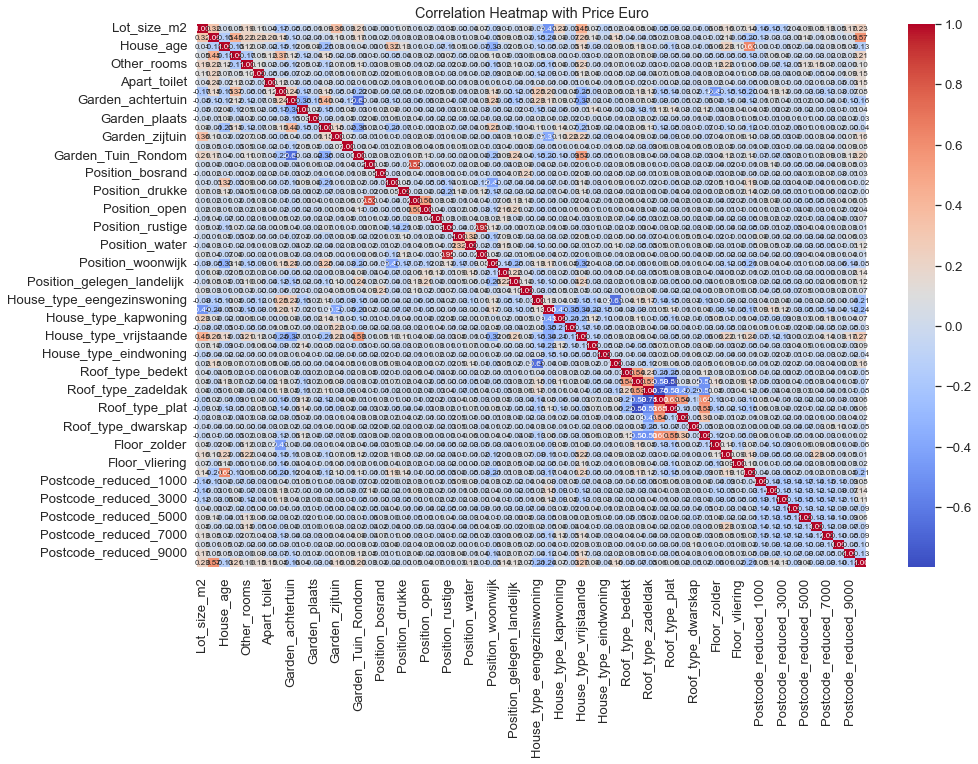

In [93]:
correlations_2 = X_train_with_target2.corr()

print(correlations_2['Price_euro'].sort_values(ascending=False))

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlations_2, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap with Price Euro')
plt.show()


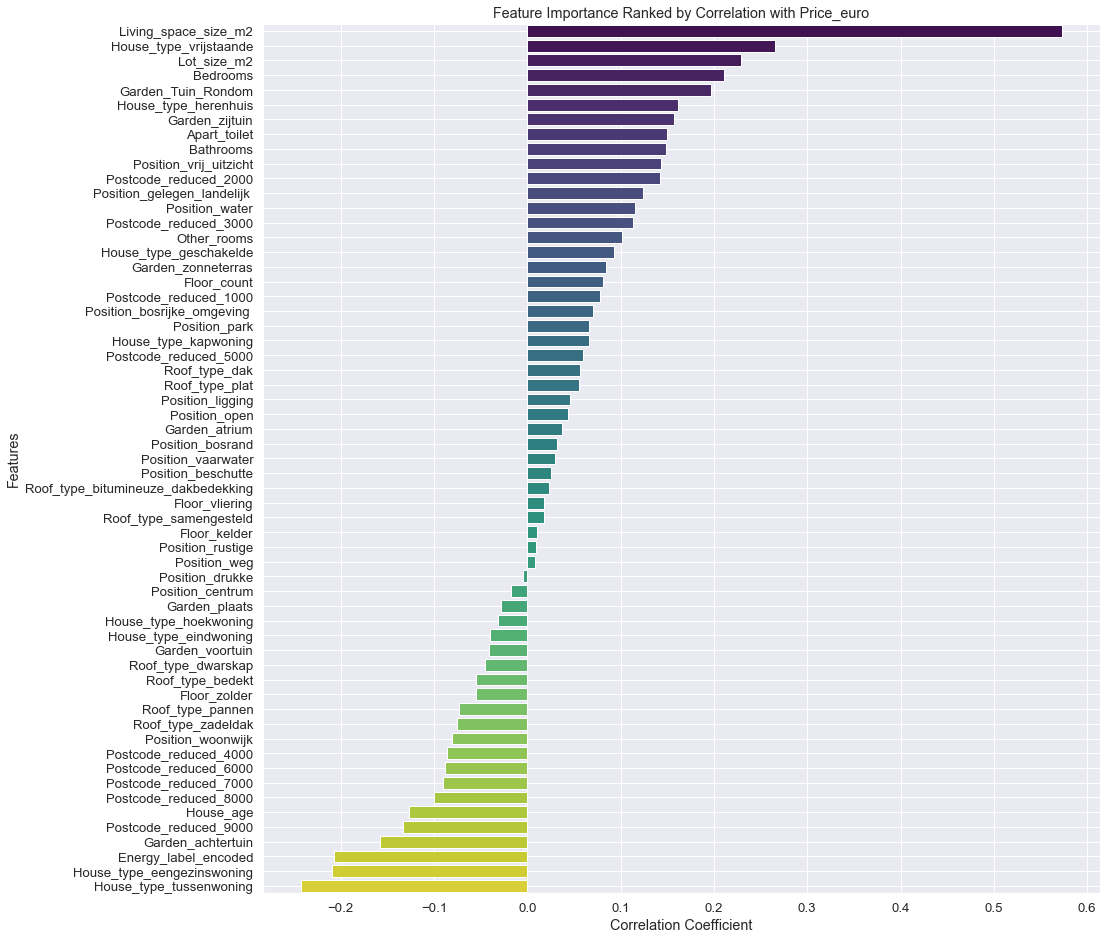

In [94]:
correlation_bar2 = X_train_with_target2.corr()['Price_euro'].sort_values(ascending=False)

correlation_df2 = pd.DataFrame(correlation_bar2).reset_index()
correlation_df2.columns = ['Feature', 'Correlation']

correlation_df2 = correlation_df2[correlation_df2.Feature != 'Price_euro']

# Plotting
plt.figure(figsize=(15, 16))  
sns.barplot(x='Correlation', y='Feature', data=correlation_df2, palette="viridis")
plt.title('Feature Importance Ranked by Correlation with Price_euro')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()


## 4.5 log transform and scaling

In [95]:
# Log Transformation
for col in ['Lot_size_m2', 'Living_space_size_m2', 'House_age']:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

# Log transform the target variable
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [96]:
X_train.head()

Lot_size_m2  Living_space_size_m2  House_age  Bedrooms  Other_rooms  \
4974     0.698135              5.081404   3.970292         6            2   
4973     5.736572              5.225747   2.833213         0            3   
3023     5.043425              4.356709   4.634729         3            1   
1678     5.087596              4.905275   3.871201         4            1   
695      4.912655              4.663439   4.477337         4            1   

      Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  Garden_atrium  \
4974          1             1            2                  1              0   
4973          2             1            3                  1              0   
3023          1             0            2                  1              0   
1678          1             1            3                  1              0   
695           1             0            3                  1              0   

      ...  Energy_label_encoded  Postcode_reduced_1000  Postcode_reduced_2000  \
4974  ...                     4                    0.0                    0.0   
4973  ...                     0                    0.0                    0.0   
3023  ...                     9                    1.0                    0.0   
1678  ...                     5                    0.0                    0.0   
695   ...                     5                    0.0                    0.0   

      Postcode_reduced_3000  Postcode_reduced_4000  Postcode_reduced_5000  \
4974                    0.0                    0.0                    0.0   
4973                    0.0                    1.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    1.0                    0.0   
695                     0.0                    0.0                    1.0   

      Postcode_reduced_6000  Postcode_reduced_7000  Postcode_reduced_8000  \
4974                    1.0                    0.0                    0.0   
4973                    0.0                    0.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    0.0                    0.0   
695                     0.0                    0.0                    0.0   

      Postcode_reduced_9000  
4974                    0.0  
4973                    0.0  
3023                    0.0  
1678                    0.0  
695                     0.0  

[5 rows x 59 columns]

In [97]:
scaler = MinMaxScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [98]:
X_train.describe()

Lot_size_m2  Living_space_size_m2    House_age     Bedrooms  \
count  2904.000000           2904.000000  2904.000000  2904.000000   
mean      0.768082              0.554087     0.614879     0.518497   
std       0.130352              0.159353     0.117776     0.130252   
min       0.000000              0.000000     0.000000     0.000000   
25%       0.719279              0.456398     0.560261     0.428571   
50%       0.766719              0.553348     0.634214     0.571429   
75%       0.835468              0.654821     0.682476     0.571429   
max       1.000000              1.000000     1.000000     1.000000   

       Other_rooms    Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  \
count  2904.000000  2904.000000   2904.000000  2904.000000        2904.000000   
mean      0.153160     0.038567      0.344812     0.427973           0.917700   
std       0.082877     0.137244      0.137582     0.099787           0.274869   
min       0.000000     0.000000      0.000000     0.000000           0.000000   
25%       0.111111     0.000000      0.333333     0.333333           1.000000   
50%       0.111111     0.000000      0.333333     0.500000           1.000000   
75%       0.222222     0.000000      0.333333     0.500000           1.000000   
max       1.000000     1.000000      1.000000     1.000000           1.000000   

       Garden_atrium  ...  Energy_label_encoded  Postcode_reduced_1000  \
count    2904.000000  ...           2904.000000            2904.000000   
mean        0.013430  ...              4.304408               0.150138   
std         0.115126  ...              2.680025               0.357268   
min         0.000000  ...              0.000000               0.000000   
25%         0.000000  ...              4.000000               0.000000   
50%         0.000000  ...              5.000000               0.000000   
75%         0.000000  ...              6.000000               0.000000   
max         1.000000  ...             10.000000               1.000000   

       Postcode_reduced_2000  Postcode_reduced_3000  Postcode_reduced_4000  \
count            2904.000000            2904.000000            2904.000000   
mean                0.103994               0.175620               0.103650   
std                 0.305306               0.380562               0.304859   
min                 0.000000               0.000000               0.000000   
25%                 0.000000               0.000000               0.000000   
50%                 0.000000               0.000000               0.000000   
75%                 0.000000               0.000000               0.000000   
max                 1.000000               1.000000               1.000000   

       Postcode_reduced_5000  Postcode_reduced_6000  Postcode_reduced_7000  \
count            2904.000000            2904.000000            2904.000000   
mean                0.133609               0.104683               0.117424   
std                 0.340290               0.306198               0.321981   
min                 0.000000               0.000000               0.000000   
25%                 0.000000               0.000000               0.000000   
50%                 0.000000               0.000000               0.000000   
75%                 0.000000               0.000000               0.000000   
max                 1.000000               1.000000               1.000000   

       Postcode_reduced_8000  Postcode_reduced_9000  
count            2904.000000            2904.000000  
mean                0.065427               0.045455  
std                 0.247320               0.208335  
min                 0.000000               0.000000  
25%                 0.000000               0.000000  
50%                 0.000000               0.000000  
75%                 0.000000               0.000000  
max                 1.000000               1.000000  

[8 rows x 59 columns]

In [99]:
X_train.head()

Lot_size_m2  Living_space_size_m2  House_age  Bedrooms  Other_rooms  \
4974     0.000170              0.766741   0.654005  0.857143     0.222222   
4973     0.858369              0.871540   0.466700  0.000000     0.333333   
3023     0.740305              0.240580   0.763454  0.428571     0.111111   
1678     0.747829              0.638863   0.637682  0.571429     0.111111   
695      0.718031              0.463280   0.737528  0.571429     0.111111   

      Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  Garden_atrium  \
4974        0.0      0.333333     0.333333                  1              0   
4973        0.5      0.333333     0.500000                  1              0   
3023        0.0      0.000000     0.333333                  1              0   
1678        0.0      0.333333     0.500000                  1              0   
695         0.0      0.000000     0.500000                  1              0   

      ...  Energy_label_encoded  Postcode_reduced_1000  Postcode_reduced_2000  \
4974  ...                     4                    0.0                    0.0   
4973  ...                     0                    0.0                    0.0   
3023  ...                     9                    1.0                    0.0   
1678  ...                     5                    0.0                    0.0   
695   ...                     5                    0.0                    0.0   

      Postcode_reduced_3000  Postcode_reduced_4000  Postcode_reduced_5000  \
4974                    0.0                    0.0                    0.0   
4973                    0.0                    1.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    1.0                    0.0   
695                     0.0                    0.0                    1.0   

      Postcode_reduced_6000  Postcode_reduced_7000  Postcode_reduced_8000  \
4974                    1.0                    0.0                    0.0   
4973                    0.0                    0.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    0.0                    0.0   
695                     0.0                    0.0                    0.0   

      Postcode_reduced_9000  
4974                    0.0  
4973                    0.0  
3023                    0.0  
1678                    0.0  
695                     0.0  

[5 rows x 59 columns]

## 4.6 check final correlations

In [100]:
X_train_with_target3 = X_train.copy()
X_train_with_target3['Price_euro'] = y_train

In [101]:
X_train_with_target3.head()

Lot_size_m2  Living_space_size_m2  House_age  Bedrooms  Other_rooms  \
4974     0.000170              0.766741   0.654005  0.857143     0.222222   
4973     0.858369              0.871540   0.466700  0.000000     0.333333   
3023     0.740305              0.240580   0.763454  0.428571     0.111111   
1678     0.747829              0.638863   0.637682  0.571429     0.111111   
695      0.718031              0.463280   0.737528  0.571429     0.111111   

      Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  Garden_atrium  \
4974        0.0      0.333333     0.333333                  1              0   
4973        0.5      0.333333     0.500000                  1              0   
3023        0.0      0.000000     0.333333                  1              0   
1678        0.0      0.333333     0.500000                  1              0   
695         0.0      0.000000     0.500000                  1              0   

      ...  Postcode_reduced_1000  Postcode_reduced_2000  \
4974  ...                    0.0                    0.0   
4973  ...                    0.0                    0.0   
3023  ...                    1.0                    0.0   
1678  ...                    0.0                    0.0   
695   ...                    0.0                    0.0   

      Postcode_reduced_3000  Postcode_reduced_4000  Postcode_reduced_5000  \
4974                    0.0                    0.0                    0.0   
4973                    0.0                    1.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    1.0                    0.0   
695                     0.0                    0.0                    1.0   

      Postcode_reduced_6000  Postcode_reduced_7000  Postcode_reduced_8000  \
4974                    1.0                    0.0                    0.0   
4973                    0.0                    0.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    0.0                    0.0   
695                     0.0                    0.0                    0.0   

      Postcode_reduced_9000  Price_euro  
4974                    0.0   13.304687  
4973                    0.0   13.208543  
3023                    0.0   12.765691  
1678                    0.0   12.427218  
695                     0.0   12.765691  

[5 rows x 60 columns]

Price_euro                            1.000000
Living_space_size_m2                  0.565766
House_type_vrijstaande                0.246989
Bedrooms                              0.219468
Garden_Tuin_Rondom                    0.182352
Garden_zijtuin                        0.154052
House_type_herenhuis                  0.149792
Postcode_reduced_2000                 0.148524
Apart_toilet                          0.146084
Bathrooms                             0.138071
Position_vrij_uitzicht                0.137990
Postcode_reduced_3000                 0.124696
Position_gelegen_landelijk            0.114756
Position_water                        0.111338
Floor_count                           0.101520
House_type_geschakelde                0.090549
Postcode_reduced_1000                 0.088902
Other_rooms                           0.086680
Garden_zonneterras                    0.080607
Position_bosrijke_omgeving            0.068324
Position_park                         0.067551
House_type_ka

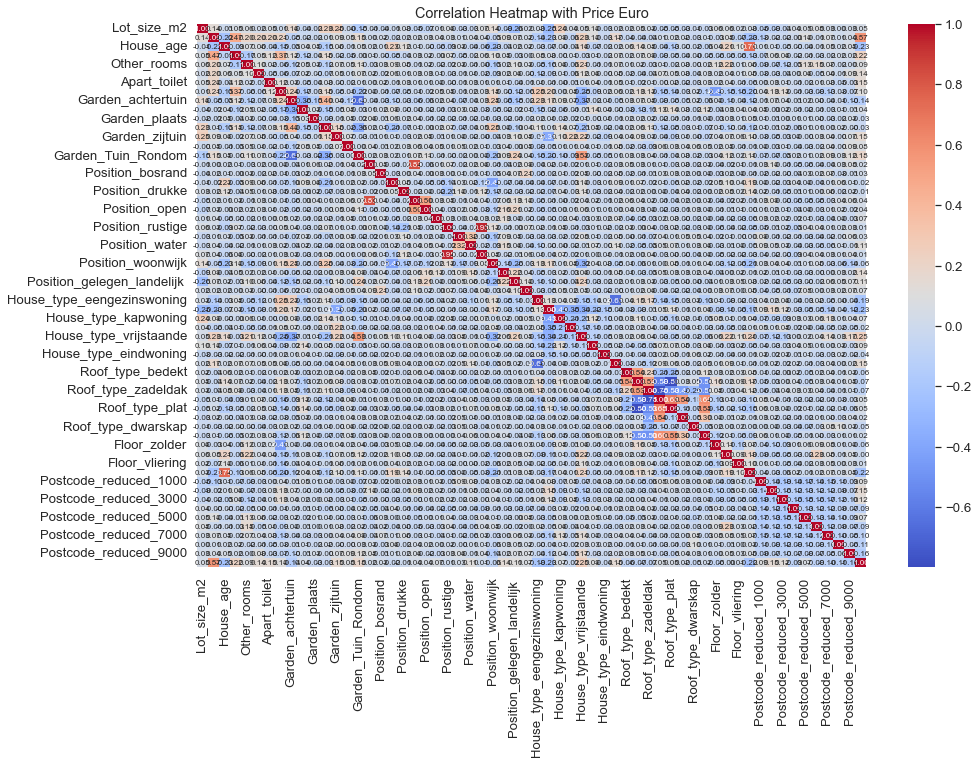

In [102]:
correlations_3 = X_train_with_target3.corr()

print(correlations_3['Price_euro'].sort_values(ascending=False))

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlations_3, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap with Price Euro')
plt.show()



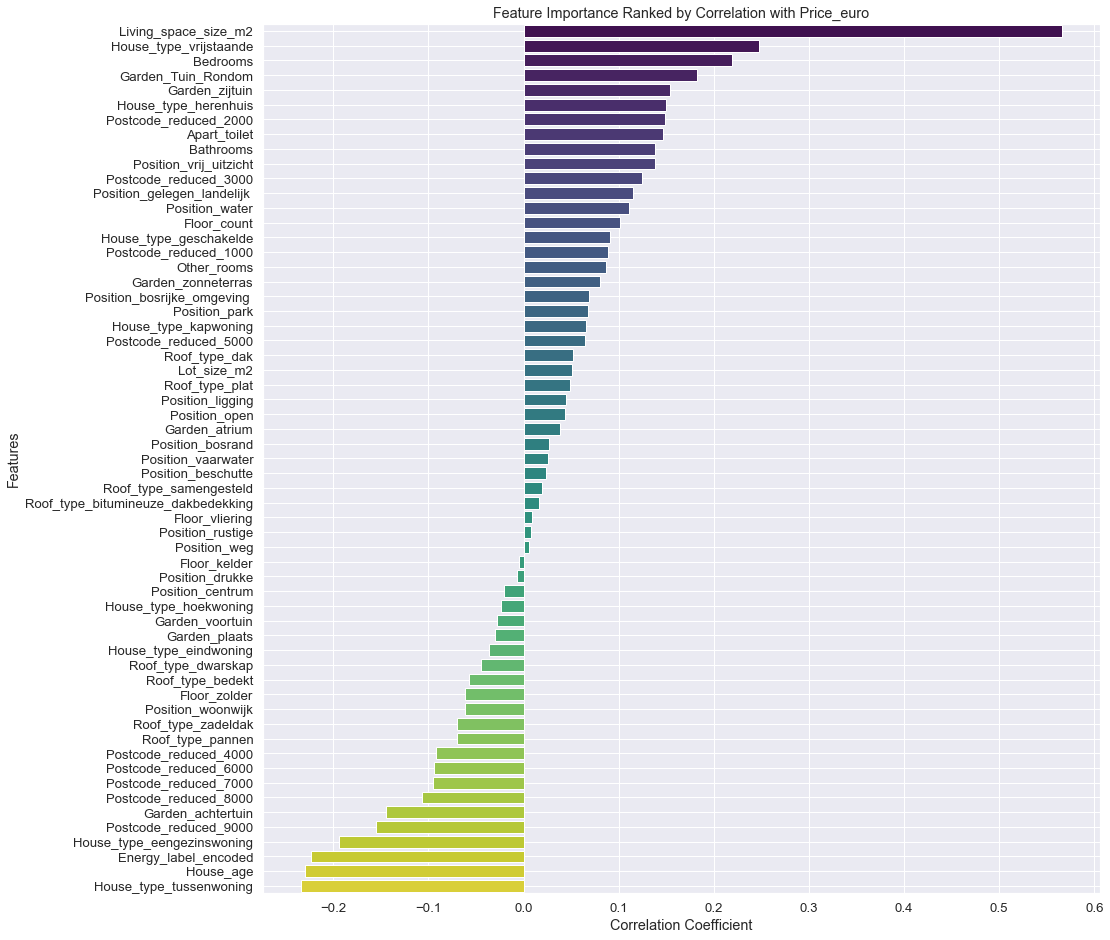

In [103]:
# Calculate the correlation with the target variable
correlation_bar3 = X_train_with_target3.corr()['Price_euro'].sort_values(ascending=False)

correlation_df3 = pd.DataFrame(correlation_bar3).reset_index()
correlation_df3.columns = ['Feature', 'Correlation']

correlation_df3 = correlation_df3[correlation_df3.Feature != 'Price_euro']

# Plotting
plt.figure(figsize=(15, 16)) 
sns.barplot(x='Correlation', y='Feature', data=correlation_df3, palette="viridis")
plt.title('Feature Importance Ranked by Correlation with Price_euro')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()


In [104]:
print(correlations_3['Price_euro'].sort_values(ascending=False))

Price_euro                            1.000000
Living_space_size_m2                  0.565766
House_type_vrijstaande                0.246989
Bedrooms                              0.219468
Garden_Tuin_Rondom                    0.182352
Garden_zijtuin                        0.154052
House_type_herenhuis                  0.149792
Postcode_reduced_2000                 0.148524
Apart_toilet                          0.146084
Bathrooms                             0.138071
Position_vrij_uitzicht                0.137990
Postcode_reduced_3000                 0.124696
Position_gelegen_landelijk            0.114756
Position_water                        0.111338
Floor_count                           0.101520
House_type_geschakelde                0.090549
Postcode_reduced_1000                 0.088902
Other_rooms                           0.086680
Garden_zonneterras                    0.080607
Position_bosrijke_omgeving            0.068324
Position_park                         0.067551
House_type_ka

In [105]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2904 entries, 4974 to 4252
Data columns (total 59 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Lot_size_m2                         2904 non-null   float64
 1   Living_space_size_m2                2904 non-null   float64
 2   House_age                           2904 non-null   float64
 3   Bedrooms                            2904 non-null   float64
 4   Other_rooms                         2904 non-null   float64
 5   Bathrooms                           2904 non-null   float64
 6   Apart_toilet                        2904 non-null   float64
 7   Floor_count                         2904 non-null   float64
 8   Garden_achtertuin                   2904 non-null   int64  
 9   Garden_atrium                       2904 non-null   int64  
 10  Garden_plaats                       2904 non-null   int64  
 11  Garden_voortuin                     2904

In [106]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 2904 entries, 4974 to 4252
Series name: Price_euro
Non-Null Count  Dtype  
--------------  -----  
2904 non-null   float64
dtypes: float64(1)
memory usage: 45.4 KB


In [107]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 838 to 1152
Data columns (total 59 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Lot_size_m2                         727 non-null    float64
 1   Living_space_size_m2                727 non-null    float64
 2   House_age                           727 non-null    float64
 3   Bedrooms                            727 non-null    float64
 4   Other_rooms                         727 non-null    float64
 5   Bathrooms                           727 non-null    float64
 6   Apart_toilet                        727 non-null    float64
 7   Floor_count                         727 non-null    float64
 8   Garden_achtertuin                   727 non-null    int64  
 9   Garden_atrium                       727 non-null    int64  
 10  Garden_plaats                       727 non-null    int64  
 11  Garden_voortuin                     727 no

In [108]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 727 entries, 838 to 1152
Series name: Price_euro
Non-Null Count  Dtype  
--------------  -----  
727 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [109]:
X_train.head()

Lot_size_m2  Living_space_size_m2  House_age  Bedrooms  Other_rooms  \
4974     0.000170              0.766741   0.654005  0.857143     0.222222   
4973     0.858369              0.871540   0.466700  0.000000     0.333333   
3023     0.740305              0.240580   0.763454  0.428571     0.111111   
1678     0.747829              0.638863   0.637682  0.571429     0.111111   
695      0.718031              0.463280   0.737528  0.571429     0.111111   

      Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  Garden_atrium  \
4974        0.0      0.333333     0.333333                  1              0   
4973        0.5      0.333333     0.500000                  1              0   
3023        0.0      0.000000     0.333333                  1              0   
1678        0.0      0.333333     0.500000                  1              0   
695         0.0      0.000000     0.500000                  1              0   

      ...  Energy_label_encoded  Postcode_reduced_1000  Postcode_reduced_2000  \
4974  ...                     4                    0.0                    0.0   
4973  ...                     0                    0.0                    0.0   
3023  ...                     9                    1.0                    0.0   
1678  ...                     5                    0.0                    0.0   
695   ...                     5                    0.0                    0.0   

      Postcode_reduced_3000  Postcode_reduced_4000  Postcode_reduced_5000  \
4974                    0.0                    0.0                    0.0   
4973                    0.0                    1.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    1.0                    0.0   
695                     0.0                    0.0                    1.0   

      Postcode_reduced_6000  Postcode_reduced_7000  Postcode_reduced_8000  \
4974                    1.0                    0.0                    0.0   
4973                    0.0                    0.0                    0.0   
3023                    0.0                    0.0                    0.0   
1678                    0.0                    0.0                    0.0   
695                     0.0                    0.0                    0.0   

      Postcode_reduced_9000  
4974                    0.0  
4973                    0.0  
3023                    0.0  
1678                    0.0  
695                     0.0  

[5 rows x 59 columns]

In [110]:
X_test.head()

Lot_size_m2  Living_space_size_m2  House_age  Bedrooms  Other_rooms  \
838      0.840423              0.594511   0.637682  0.571429     0.111111   
4319     0.722968              0.212104   0.763454  0.285714     0.111111   
525      0.763872              0.391336   0.650867  0.571429     0.111111   
235      0.774085              0.660063   0.641079  0.571429     0.111111   
3410     0.758031              0.588772   0.456714  0.571429     0.222222   

      Bathrooms  Apart_toilet  Floor_count  Garden_achtertuin  Garden_atrium  \
838         0.0      0.333333     0.500000                  1              0   
4319        0.0      0.333333     0.333333                  1              0   
525         0.0      0.333333     0.333333                  1              0   
235         0.0      0.333333     0.333333                  1              0   
3410        0.0      0.333333     0.500000                  1              0   

      ...  Energy_label_encoded  Postcode_reduced_1000  Postcode_reduced_2000  \
838   ...                     5                    0.0                    0.0   
4319  ...                     7                    0.0                    0.0   
525   ...                     7                    0.0                    0.0   
235   ...                     5                    0.0                    0.0   
3410  ...                     0                    0.0                    0.0   

      Postcode_reduced_3000  Postcode_reduced_4000  Postcode_reduced_5000  \
838                     0.0                    1.0                    0.0   
4319                    0.0                    1.0                    0.0   
525                     0.0                    1.0                    0.0   
235                     0.0                    0.0                    0.0   
3410                    0.0                    0.0                    1.0   

      Postcode_reduced_6000  Postcode_reduced_7000  Postcode_reduced_8000  \
838                     0.0                    0.0                    0.0   
4319                    0.0                    0.0                    0.0   
525                     0.0                    0.0                    0.0   
235                     1.0                    0.0                    0.0   
3410                    0.0                    0.0                    0.0   

      Postcode_reduced_9000  
838                     0.0  
4319                    0.0  
525                     0.0  
235                     0.0  
3410                    0.0  

[5 rows x 59 columns]

# 5. Training models, model validation

## 5.1 Linear Regression (baseline)

In [111]:
# Initialize Linear Regression model
lr_model = LinearRegression()

kf_lr = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_lr = cross_val_score(lr_model, X_train, y_train, cv=kf_lr, scoring='neg_mean_squared_error')

average_rmse_lr = np.sqrt(-np.mean(cv_scores_lr))
print("Average RMSE (CV):", average_rmse_lr)

lr_model.fit(X_train, y_train)

y_pred_test_lr = lr_model.predict(X_test)

test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
test_mae_lr = mean_absolute_error(y_test, y_pred_test_lr)
test_r2_lr = r2_score(y_test, y_pred_test_lr)

print("Test RMSE:", test_rmse_lr)
print("Test MAE:", test_mae_lr)
print("Test R²:", test_r2_lr)


Average RMSE (CV): 19132629036.211987
Test RMSE: 0.16626263805471247
Test MAE: 0.1297285600239037
Test R²: 0.5705364745236687


## 5.2 XGBoost

### Without hyperparameter tuning

In [112]:
kf_xg_simple = KFold(n_splits=5, shuffle=True, random_state=42)


In [113]:
xgb_model_simple = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)

In [114]:
rmse_scores_xgb_simple = []
mae_scores_xgb_simple = []
r2_scores_xgb_simple = []

In [115]:
# Perform the K-Fold cross-validation
for train_index_xgbsimple, val_index_xgbsimple in kf_xg_simple.split(X_train):
    X_train_fold_xgbsimple, X_val_fold_xgbsimple = X_train.iloc[train_index_xgbsimple], X_train.iloc[val_index_xgbsimple]
    y_train_fold_xgbsimple, y_val_fold_xgbsimple = y_train.iloc[train_index_xgbsimple], y_train.iloc[val_index_xgbsimple]

    xgb_model_simple.fit(X_train_fold_xgbsimple, y_train_fold_xgbsimple)

    y_pred_fold_xgbsimple = xgb_model_simple.predict(X_val_fold_xgbsimple)

    rmse_fold_xgbsimple = np.sqrt(mean_squared_error(y_val_fold_xgbsimple, y_pred_fold_xgbsimple))
    mae_fold_xgbsimple = mean_absolute_error(y_val_fold_xgbsimple, y_pred_fold_xgbsimple)
    r2_fold_xgbsimple = r2_score(y_val_fold_xgbsimple, y_pred_fold_xgbsimple)

    rmse_scores_xgb_simple.append(rmse_fold_xgbsimple)
    mae_scores_xgb_simple.append(mae_fold_xgbsimple)
    r2_scores_xgb_simple.append(r2_fold_xgbsimple)

In [116]:
print("Cross-validated RMSE:", np.mean(rmse_scores_xgb_simple))
print("Cross-validated MAE:", np.mean(mae_scores_xgb_simple))
print("Cross-validated R²:", np.mean(r2_scores_xgb_simple))

Cross-validated RMSE: 0.16690298976613374
Cross-validated MAE: 0.13041280191163718
Cross-validated R²: 0.6173457843333623


In [117]:
y_pred_xgb_simple = xgb_model_simple.predict(X_test)

rmse_xgb_simple = np.sqrt(mean_squared_error(y_test, y_pred_xgb_simple))
mae_xgb_simple = mean_absolute_error(y_test, y_pred_xgb_simple)
r2_xgb_simple = r2_score(y_test, y_pred_xgb_simple)

print(f"XGBoost - Test RMSE: {rmse_xgb_simple:.5f}")
print(f"XGBoost - Test MAE: {mae_xgb_simple:.5f}")
print(f"XGBoost - Test R²: {r2_xgb_simple:.5f}")


XGBoost - Test RMSE: 0.16009
XGBoost - Test MAE: 0.12347
XGBoost - Test R²: 0.60186


### XGBoost with hyperparameter tuning

In [118]:
xgb_model_hyper = xgb.XGBRegressor(objective='reg:squarederror')

param_grid_xgboost = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0] 
}



In [119]:
kf_xgboost_hyper = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xgboost = GridSearchCV(estimator=xgb_model_hyper, param_grid=param_grid_xgboost, cv=kf_xgboost_hyper,
                           scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)


In [120]:
grid_search_xgboost.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None,

In [121]:
best_model_xgboost_hyper = grid_search_xgboost.best_estimator_

y_pred_xgboost_hyper = best_model_xgboost_hyper.predict(X_test)

rmse_xgboost_hyper = np.sqrt(mean_squared_error(y_test, y_pred_xgboost_hyper))
mae_xgboost_hyper = mean_absolute_error(y_test, y_pred_xgboost_hyper)
r2_xgboost_hyper = r2_score(y_test, y_pred_xgboost_hyper)


In [122]:
print("XGBoost Best parameters found: ", grid_search_xgboost.best_params_)

print("Test RMSE XGBoost: ", rmse_xgboost_hyper)
print("Test MAE: ", mae_xgboost_hyper)
print("Test R²: ", r2_xgboost_hyper)


XGBoost Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Test RMSE XGBoost:  0.1533157823568335
Test MAE:  0.11764302369542644
Test R²:  0.6348168942795253


## 5.3 CatBoost

### catboost without hyperparameter tuning

In [123]:
model_CatBoost_simple = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=False  
)

In [124]:
kf_catboost_simple = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_catboost_simple = []
mae_scores_catboost_simple = []
r2_scores_catboost_simple = []

In [125]:
for train_index_CatBoost_simple, val_index_CatBoost_simple in kf_catboost_simple.split(X_train):
    X_train_fold_CatBoost_simple, X_val_fold_CatBoost_simple = X_train.iloc[train_index_CatBoost_simple], X_train.iloc[val_index_CatBoost_simple]
    y_train_fold_CatBoost_simple, y_val_fold_CatBoost_simple = y_train.iloc[train_index_CatBoost_simple], y_train.iloc[val_index_CatBoost_simple]

    model_CatBoost_simple.fit(X_train_fold_CatBoost_simple, y_train_fold_CatBoost_simple)

    y_pred_fold_CatBoost_simple = model_CatBoost_simple.predict(X_val_fold_CatBoost_simple)

    rmse_CatBoost_simple = np.sqrt(mean_squared_error(y_val_fold_CatBoost_simple, y_pred_fold_CatBoost_simple))
    mae_CatBoost_simple = mean_absolute_error(y_val_fold_CatBoost_simple, y_pred_fold_CatBoost_simple)
    r2_CatBoost_simple = r2_score(y_val_fold_CatBoost_simple, y_pred_fold_CatBoost_simple)

    rmse_scores_catboost_simple.append(rmse_CatBoost_simple)
    mae_scores_catboost_simple.append(mae_CatBoost_simple)
    r2_scores_catboost_simple.append(r2_CatBoost_simple)

In [126]:
# Output average metrics
print("Average RMSE:", np.mean(rmse_scores_catboost_simple))
print("Average MAE:", np.mean(mae_scores_catboost_simple))
print("Average R²:", np.mean(r2_scores_catboost_simple))


Average RMSE: 0.1604399761948263
Average MAE: 0.12452079467499125
Average R²: 0.6464187600708085


In [127]:
y_test_pred_CatBoost_simple = model_CatBoost_simple.predict(X_test)

test_rmse_CatBoost_simple = np.sqrt(mean_squared_error(y_test, y_test_pred_CatBoost_simple))
test_mae_CatBoost_simple = mean_absolute_error(y_test, y_test_pred_CatBoost_simple)
test_r2_CatBoost_simple = r2_score(y_test, y_test_pred_CatBoost_simple)

# Print test scores
print("Test RMSE: ", test_rmse_CatBoost_simple)
print("Test MAE: ", test_mae_CatBoost_simple)
print("Test R²: ", test_r2_CatBoost_simple)

Test RMSE:  0.1527224334104555
Test MAE:  0.11709674238856413
Test R²:  0.6376380222549143


### catboost with hyperparameter tuning

In [128]:
# Initialize CatBoostRegressor
model_CatBoost_hyper = CatBoostRegressor(
    iterations=500,  
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

In [129]:
# Define the parameter grid specifically for CatBoost tuning
param_grid_CatBoost_hyper = {
    'iterations': [300, 500, 700],  
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]  
}

kf_CatBoost_hyper = KFold(n_splits=5, shuffle=True, random_state=42)

In [130]:
# Initialize GridSearchCV specifically for CatBoost
grid_search_CatBoost = GridSearchCV(estimator=model_CatBoost_hyper, param_grid=param_grid_CatBoost_hyper, 
                           cv=kf_CatBoost_hyper, scoring='neg_root_mean_squared_error', 
                           verbose=3, n_jobs=-1)
grid_search_CatBoost.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
0:	learn: 0.2651381	total: 4.5ms	remaining: 2.25s
100:	learn: 0.1605534	total: 434ms	remaining: 1.72s
200:	learn: 0.1446534	total: 840ms	remaining: 1.25s
300:	learn: 0.1335416	total: 1.19s	remaining: 788ms
400:	learn: 0.1258461	total: 1.56s	remaining: 384ms
499:	learn: 0.1194114	total: 1.91s	remaining: 0us


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000002125FB64670>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [300, 500, 700],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [131]:
# Best parameters and best score for CatBoost
print("Best parameters found for CatBoost: ", grid_search_CatBoost.best_params_)
print("Best RMSE found for CatBoost: ", -grid_search_CatBoost.best_score_)

best_model_CatBoost = grid_search_CatBoost.best_estimator_
y_pred_CatBoost_hyper = best_model_CatBoost.predict(X_test)
rmse_CatBoost_hyper = np.sqrt(mean_squared_error(y_test, y_pred_CatBoost_hyper))
mae_CatBoost_hyper = mean_absolute_error(y_test, y_pred_CatBoost_hyper)
r2_CatBoost_hyper = r2_score(y_test, y_pred_CatBoost_hyper)

print("Test RMSE for CatBoost:", rmse_CatBoost_hyper)
print("Test MAE for CatBoost:", mae_CatBoost_hyper)
print("Test R2 for CatBoost:", r2_CatBoost_hyper)


Best parameters found for CatBoost:  {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Best RMSE found for CatBoost:  0.1604399761948263
Test RMSE for CatBoost: 0.15001772711108458
Test MAE for CatBoost: 0.11510311933300825
Test R2 for CatBoost: 0.650359193536765


## 5.4 Elastic net

without hyperparameter tuning

In [132]:
elastic_net_simple = ElasticNetCV(cv=5, random_state=42)

elastic_net_simple.fit(X_train, y_train)


ElasticNetCV(cv=5, random_state=42)

In [133]:
y_pred_en_simple = elastic_net_simple.predict(X_test)

rmse_en_simple = np.sqrt(mean_squared_error(y_test, y_pred_en_simple))
mae_en_simple = mean_absolute_error(y_test, y_pred_en_simple)
r2_en_simple = r2_score(y_test, y_pred_en_simple)


In [134]:
print("Alpha: ", elastic_net_simple.alpha_)
print("L1 ratio: ", elastic_net_simple.l1_ratio_)

# Print the test metrics
print("Test RMSE: ", rmse_en_simple)
print("Test MAE: ", mae_en_simple)
print("Test R^2: ", r2_en_simple)


Alpha:  0.0005649002402850918
L1 ratio:  0.5
Test RMSE:  0.16464081431297461
Test MAE:  0.12842526607990074
Test R^2:  0.5788740907825896


### Elastic net with hyperparameter tuning

In [135]:
elastic_net_hyper = ElasticNetCV(alphas=[0.0001, 0.001, 0.1, 1, 10], l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=42)
elastic_net_hyper.fit(X_train, y_train)


D:\ANACONDA\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056908985687073255, tolerance: 0.016775706460100584
  model = cd_fast.enet_coordinate_descent_gram(
D:\ANACONDA\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2030089068584644, tolerance: 0.016756882328586943
  model = cd_fast.enet_coordinate_descent_gram(
D:\ANACONDA\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03034868675078428, tolerance: 0.016796986147909383
  model = cd_fast.enet_coordinate_descent_gram(
D:\ANACONDA\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not c

ElasticNetCV(alphas=[0.0001, 0.001, 0.1, 1, 10], cv=5, l1_ratio=[0.1, 0.5, 0.9],
             random_state=42)

In [136]:
y_pred_en_hyper = elastic_net_hyper.predict(X_test)

rmse_en_hyper = np.sqrt(mean_squared_error(y_test, y_pred_en_hyper))
mae_en_hyper = mean_absolute_error(y_test, y_pred_en_hyper)
r2_en_hyper = r2_score(y_test, y_pred_en_hyper)


In [137]:
print("Alpha: ", elastic_net_hyper.alpha_)
print("L1 ratio: ", elastic_net_hyper.l1_ratio_)

print("Test RMSE hyperparameter tuning EN: ", rmse_en_hyper)
print("Test MAE hyperparameter tuning EN: ", mae_en_hyper)
print("Test R^2 hyperparameter tuning EN: ", r2_en_hyper)


Alpha:  0.001
L1 ratio:  0.1
Test RMSE hyperparameter tuning EN:  0.16460137581057735
Test MAE hyperparameter tuning EN:  0.1287229875970708
Test R^2 hyperparameter tuning EN:  0.5790758218784686


## 5.5 TabNet

### without hyperparameter tuning

In [138]:
X_train_np = X_train.values
y_train_np = y_train.values.flatten().reshape(-1, 1)
X_test_np = X_test.values
y_test_np = y_test.values.flatten().reshape(-1, 1)

In [139]:
# Initialize TabNet model
model_tabnet_simple = TabNetRegressor(verbose=0)  # Set verbose to 0 to minimize output during training

# Set up KFold cross-validation
kf_tabnet_simple = KFold(n_splits=5, random_state=42, shuffle=True)

# Perform K-Fold Cross-Validation
for fold_tabnet_simple, (train_idx_tabnet_simple, val_idx_tabnet_simple) in enumerate(kf_tabnet_simple.split(X_train_np)):
    X_train_fold_tabnet_simple, y_train_fold_tabnet_simple = X_train_np[train_idx_tabnet_simple], y_train_np[train_idx_tabnet_simple]
    X_val_fold_tabnet_simple, y_val_fold_tabnet_simple = X_train_np[val_idx_tabnet_simple], y_train_np[val_idx_tabnet_simple]

    # Train the model
    model_tabnet_simple.fit(
        X_train=X_train_fold_tabnet_simple, y_train=y_train_fold_tabnet_simple,
        eval_set=[(X_val_fold_tabnet_simple, y_val_fold_tabnet_simple)],
        max_epochs=100,  # Define a reasonable number of epochs
        patience=10,     # Early stopping based on validation loss
        batch_size=1024, # Define batch size
        virtual_batch_size=128, # Size of mini batches for "Ghost Batch Normalization"
        num_workers=0,   # Number of workers; can adjust based on your machine's specification
        drop_last=False  # Whether to drop the last incomplete batch
    )

Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_val_0_mse = 0.0576


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 61 with best_epoch = 51 and best_val_0_mse = 0.09408


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 73 with best_epoch = 63 and best_val_0_mse = 0.0707


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 70 with best_epoch = 60 and best_val_0_mse = 0.06912


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 87 with best_epoch = 77 and best_val_0_mse = 0.06019


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [140]:
# Predict on test data and calculate metrics
y_pred_test_tabnet_simple = model_tabnet_simple.predict(X_test_np)
test_rmse_tabnet_simple = np.sqrt(mean_squared_error(y_test_np, y_pred_test_tabnet_simple))
test_mae_tabnet_simple = mean_absolute_error(y_test_np, y_pred_test_tabnet_simple)
test_r2_tabnet_simple = r2_score(y_test_np, y_pred_test_tabnet_simple)

# Print the test metrics
print(f"Test RMSE TabNet: {test_rmse_tabnet_simple}")
print(f"Test MAE TabNet: {test_mae_tabnet_simple}")
print(f"Test R² TabNet: {test_r2_tabnet_simple}")


Test RMSE TabNet: 0.2362795664196205
Test MAE TabNet: 0.18969053796308974
Test R² TabNet: 0.13266018855637451


### Tabnet with hyper parameter tuning

In [142]:
def objective(trial):
    # Define the hyperparameter search space using the trial object
    max_epochs = trial.suggest_int("max_epochs", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)
    n_d = trial.suggest_int("n_d", 8, 64)
    n_a = trial.suggest_int("n_a", 8, 64)
    max_steps = trial.suggest_int("max_steps", 5, 20)
    
    # Instantiate the model with suggested hyperparameters
    model_tabnet_hyper = TabNetRegressor(
        optimizer_params=dict(lr=learning_rate),
        scheduler_params={"step_size": max_steps, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        n_d=n_d,
        n_a=n_a,
        verbose=0
    )
    
    # Cross-validation setup
    kf = KFold(n_splits=3, random_state=42, shuffle=True)
    rmse_scores = []
    
    for train_index, valid_index in kf.split(X_train_np):
        X_train_fold, y_train_fold = X_train_np[train_index], y_train_np[train_index]
        X_valid_fold, y_valid_fold = X_train_np[valid_index], y_train_np[valid_index]
        
        model_tabnet_hyper.fit(
            X_train=X_train_fold, y_train=y_train_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            max_epochs=max_epochs,
            patience=5,
            batch_size=256, 
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )
        
        y_valid_pred = model_tabnet_hyper.predict(X_valid_fold)
        rmse = np.sqrt(mean_squared_error(y_valid_fold, y_valid_pred))
        rmse_scores.append(rmse)
    
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # You can increase the number of trials

print("Best trial:", study.best_trial.params)


[I 2024-05-09 22:30:47,775] A new study created in memory with name: no-name-ccf5d5a5-5b72-4105-bd58-cb402b490173
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)


Stop training because you reached max_epochs = 48 with best_epoch = 46 and best_val_0_mse = 0.24267


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 48 with best_epoch = 47 and best_val_0_mse = 0.29466


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 48 with best_epoch = 47 and best_val_0_mse = 0.30985


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:32:02,989] Trial 0 finished with value: 0.5306940674696062 and parameters: {'max_epochs': 48, 'learning_rate': 0.0015339425684750374, 'n_d': 63, 'n_a': 14, 'max_steps': 5}. Best is trial 0 with value: 0.5306940674696062.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_mse = 0.09951


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_mse = 0.11391


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_mse = 0.1169


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:32:31,608] Trial 1 finished with value: 0.33162241249281843 and parameters: {'max_epochs': 72, 'learning_rate': 0.08380539888062652, 'n_d': 28, 'n_a': 43, 'max_steps': 11}. Best is trial 1 with value: 0.33162241249281843.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_0_mse = 0.09605


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_0_mse = 0.14176


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_0_mse = 0.10792


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:33:14,745] Trial 2 finished with value: 0.3383121912283897 and parameters: {'max_epochs': 43, 'learning_rate': 0.008802736566503598, 'n_d': 31, 'n_a': 47, 'max_steps': 12}. Best is trial 1 with value: 0.33162241249281843.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 58 with best_epoch = 53 and best_val_0_mse = 0.10733


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 51 and best_val_0_mse = 0.1075


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 42 and best_val_0_mse = 0.14046


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:34:24,169] Trial 3 finished with value: 0.3434233551108658 and parameters: {'max_epochs': 100, 'learning_rate': 0.0020018108160076045, 'n_d': 27, 'n_a': 15, 'max_steps': 11}. Best is trial 1 with value: 0.33162241249281843.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_0_mse = 0.09824


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_0_mse = 0.07289


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_0_mse = 0.07504


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:35:08,591] Trial 4 finished with value: 0.2857878109716783 and parameters: {'max_epochs': 62, 'learning_rate': 0.021811407028618314, 'n_d': 16, 'n_a': 55, 'max_steps': 12}. Best is trial 4 with value: 0.2857878109716783.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)


Stop training because you reached max_epochs = 13 with best_epoch = 11 and best_val_0_mse = 0.6168


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 13 with best_epoch = 12 and best_val_0_mse = 0.64538


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 13 with best_epoch = 12 and best_val_0_mse = 0.62728


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:35:31,820] Trial 5 finished with value: 0.7935775116591796 and parameters: {'max_epochs': 13, 'learning_rate': 0.007601131305036849, 'n_d': 50, 'n_a': 54, 'max_steps': 5}. Best is trial 4 with value: 0.2857878109716783.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_mse = 0.05965


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_0_mse = 0.08224


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_0_mse = 0.07097


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:36:17,956] Trial 6 finished with value: 0.26580569752824784 and parameters: {'max_epochs': 52, 'learning_rate': 0.04225300931027175, 'n_d': 53, 'n_a': 51, 'max_steps': 7}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)


Stop training because you reached max_epochs = 52 with best_epoch = 50 and best_val_0_mse = 0.1508


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 52 with best_epoch = 51 and best_val_0_mse = 0.1499


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 52 with best_epoch = 49 and best_val_0_mse = 0.27419


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:38:01,319] Trial 7 finished with value: 0.43304690074370233 and parameters: {'max_epochs': 52, 'learning_rate': 0.0010329679645529632, 'n_d': 55, 'n_a': 43, 'max_steps': 13}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_mse = 0.09107


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_mse = 0.09574


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_0_mse = 0.08833


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:38:36,736] Trial 8 finished with value: 0.3027984558087416 and parameters: {'max_epochs': 90, 'learning_rate': 0.04920425657162722, 'n_d': 57, 'n_a': 19, 'max_steps': 20}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 52 with best_epoch = 47 and best_val_0_mse = 0.09307


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 36 and best_val_0_mse = 0.13535


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 39 and best_val_0_mse = 0.10994


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:40:01,994] Trial 9 finished with value: 0.33484890681363705 and parameters: {'max_epochs': 71, 'learning_rate': 0.0023042922061463564, 'n_d': 32, 'n_a': 51, 'max_steps': 20}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_mse = 0.08354


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_mse = 0.12883


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_0_mse = 0.09829


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:40:42,693] Trial 10 finished with value: 0.32049577798407647 and parameters: {'max_epochs': 27, 'learning_rate': 0.025412361890681693, 'n_d': 44, 'n_a': 63, 'max_steps': 8}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 43 with best_epoch = 38 and best_val_0_mse = 0.06541


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_0_mse = 0.0736


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 31 and best_val_0_mse = 0.08114


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:41:40,955] Trial 11 finished with value: 0.2706270718918374 and parameters: {'max_epochs': 70, 'learning_rate': 0.020134004709736347, 'n_d': 17, 'n_a': 29, 'max_steps': 16}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_0_mse = 0.07147


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 31 and best_val_0_mse = 0.07236


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_0_mse = 0.07909


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:42:36,699] Trial 12 finished with value: 0.2725230456546226 and parameters: {'max_epochs': 80, 'learning_rate': 0.021919283208325428, 'n_d': 8, 'n_a': 30, 'max_steps': 16}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_mse = 0.10437


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_mse = 0.10134


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_mse = 0.09071


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:43:12,831] Trial 13 finished with value: 0.3141951946290084 and parameters: {'max_epochs': 35, 'learning_rate': 0.04889033994498133, 'n_d': 43, 'n_a': 29, 'max_steps': 16}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 42 with best_epoch = 37 and best_val_0_mse = 0.07575


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_0_mse = 0.13742


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 37 and best_val_0_mse = 0.07512


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:44:11,801] Trial 14 finished with value: 0.3066705540378668 and parameters: {'max_epochs': 63, 'learning_rate': 0.005658364790452321, 'n_d': 19, 'n_a': 34, 'max_steps': 16}. Best is trial 6 with value: 0.26580569752824784.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 47 with best_epoch = 42 and best_val_0_mse = 0.05606


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_0_mse = 0.09531


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 35 and best_val_0_mse = 0.06071


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:45:19,170] Trial 15 finished with value: 0.26396437176216053 and parameters: {'max_epochs': 83, 'learning_rate': 0.014342961052777159, 'n_d': 39, 'n_a': 23, 'max_steps': 8}. Best is trial 15 with value: 0.26396437176216053.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 43 with best_epoch = 38 and best_val_0_mse = 0.08472


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 31 and best_val_0_mse = 0.11346


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 38 and best_val_0_mse = 0.12292


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:46:13,103] Trial 16 finished with value: 0.3261738022669691 and parameters: {'max_epochs': 88, 'learning_rate': 0.0036912775983537574, 'n_d': 40, 'n_a': 8, 'max_steps': 8}. Best is trial 15 with value: 0.26396437176216053.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_0_mse = 0.08778


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 25 with best_epoch = 22 and best_val_0_mse = 0.08981


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_mse = 0.13303


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:46:47,158] Trial 17 finished with value: 0.32023368392876184 and parameters: {'max_epochs': 25, 'learning_rate': 0.01292318471909706, 'n_d': 49, 'n_a': 23, 'max_steps': 8}. Best is trial 15 with value: 0.26396437176216053.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)


Stop training because you reached max_epochs = 43 with best_epoch = 39 and best_val_0_mse = 0.05269


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_0_mse = 0.07132


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_0_mse = 0.08601


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:47:37,463] Trial 18 finished with value: 0.2632939884222896 and parameters: {'max_epochs': 43, 'learning_rate': 0.03940368280314618, 'n_d': 38, 'n_a': 63, 'max_steps': 6}. Best is trial 18 with value: 0.2632939884222896.
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2955541067.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_mse = 0.08525


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 37 with best_epoch = 34 and best_val_0_mse = 0.07204


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_0_mse = 0.08829


D:\ANACONDA\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-05-09 22:48:30,054] Trial 19 finished with value: 0.28584124896783675 and parameters: {'max_epochs': 37, 'learning_rate': 0.011928431790876791, 'n_d': 37, 'n_a': 60, 'max_steps': 6}. Best is trial 18 with value: 0.2632939884222896.


Best trial: {'max_epochs': 43, 'learning_rate': 0.03940368280314618, 'n_d': 38, 'n_a': 63, 'max_steps': 6}


In [143]:
# Best parameters found
params_tabnet_hyper = study.best_trial.params

# Train the model with the best parameters
model_tabnet_hyper = TabNetRegressor(
    optimizer_params={"lr": params_tabnet_hyper['learning_rate']},
    scheduler_params={"step_size": params_tabnet_hyper['max_steps'], "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    n_d=params_tabnet_hyper['n_d'],
    n_a=params_tabnet_hyper['n_a'],
    verbose=0
)

model_tabnet_hyper.fit(
    X_train=X_train_np, 
    y_train=y_train_np,
    max_epochs=params_tabnet_hyper['max_epochs'],
    patience=10,
    batch_size=256, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Evaluate on test data
y_pred_test_hyper = model_tabnet_hyper.predict(X_test_np)
test_rmse_hyper = np.sqrt(mean_squared_error(y_test_np, y_pred_test_hyper))
test_mae_hyper = mean_absolute_error(y_test_np, y_pred_test_hyper)
test_r2_hyper = r2_score(y_test_np, y_pred_test_hyper)


D:\ANACONDA\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Test RMSE with hyperparameters: 0.29003849040228197
Test MAE with hyperparameters: 0.24561111405716968
Test R² with hyperparameters: -0.30691764895217677


In [145]:
# Print the test metrics
print(f"Test RMSE with hyperparameters: {test_rmse_hyper.round(3)}")
print(f"Test MAE with hyperparameters: {test_mae_hyper.round(3)}")
print(f"Test R² with hyperparameters: {test_r2_hyper.round(3)}")

Test RMSE with hyperparameters: 0.29
Test MAE with hyperparameters: 0.246
Test R² with hyperparameters: -0.307


# 6. Comparasion of model performance

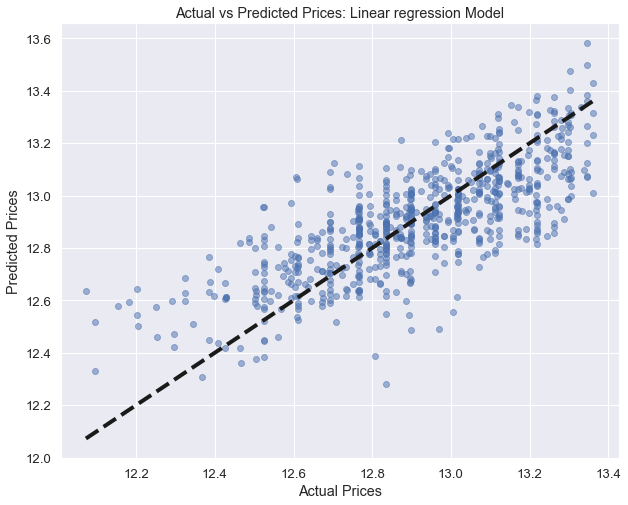

In [146]:
# liner regression, scatter plot vs actual

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_test_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices: Linear regression Model')
plt.show()


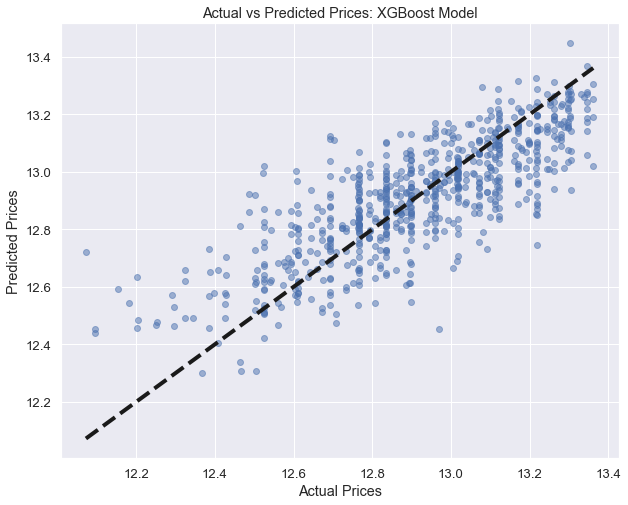

In [147]:
#xgboost

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_xgboost_hyper, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices: XGBoost Model')
plt.show()


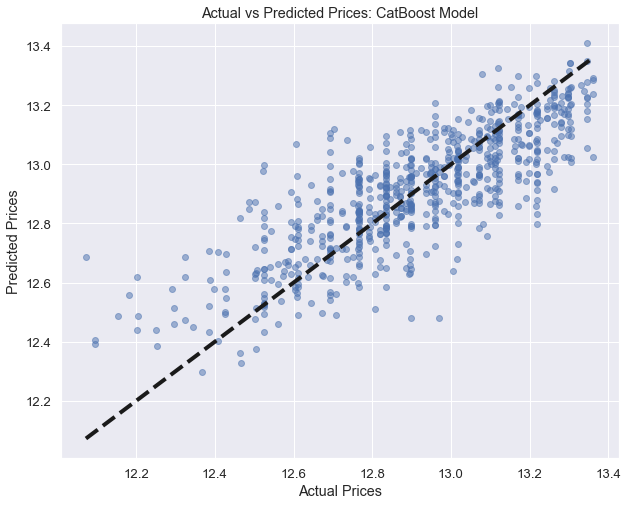

In [148]:
# Catboost
plt.figure(figsize=(10, 8))
plt.scatter(y_test,y_pred_CatBoost_hyper, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices: CatBoost Model')
plt.show()

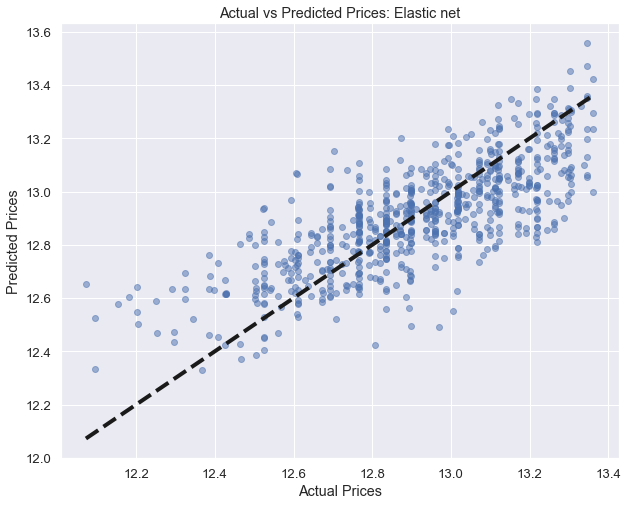

In [149]:
# EN y_test, y_pred_en
plt.figure(figsize=(10, 8))
plt.scatter(y_test,y_pred_en_hyper , alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices: Elastic net')
plt.show()



# 7. Conclusion

## How effectively can machine learning and deep learning models predict housing prices in the Netherlands, based on house characteristics and enriched geographical data?

## 7.1 Which model demonstrates the highest RMSE for Dutch housing prices when incorporating postcodes as a proxy for geographical characteristics?

In [151]:
data = {
    'Model': ['Linear Regression', 'XGBoost', 'CatBoost', 'Elastic Net','TabNet'],
    'RMSE': [test_rmse_lr, rmse_xgboost_hyper, rmse_CatBoost_hyper, rmse_en_hyper, test_rmse_hyper],
    'MAE': [test_mae_lr, mae_xgboost_hyper, mae_CatBoost_hyper, mae_en_hyper, test_mae_hyper],
    'R2': [test_r2_lr, r2_xgboost_hyper, r2_CatBoost_hyper, r2_en_hyper, test_r2_hyper]
}

score_df = pd.DataFrame(data)


In [152]:
best_rmse_model = score_df.loc[score_df['RMSE'].idxmin(), 'Model']

best_mae_model = score_df.loc[score_df['MAE'].idxmin(), 'Model']

best_r2_model = score_df.loc[score_df['R2'].idxmax(), 'Model']

print(f"Model with the best RMSE: {best_rmse_model}")
print(f"Model with the best MAE: {best_mae_model}")
print(f"Model with the best R²: {best_r2_model}")


Model with the best RMSE: CatBoost
Model with the best MAE: CatBoost
Model with the best R²: CatBoost


In [153]:
print(score_df)


               Model      RMSE       MAE        R2
0  Linear Regression  0.166263  0.129729  0.570536
1            XGBoost  0.153316  0.117643  0.634817
2           CatBoost  0.150018  0.115103  0.650359
3        Elastic Net  0.164601  0.128723  0.579076
4             TabNet  0.290038  0.245611 -0.306918


## 7.2 How does the inclusion of postcode-based geographical data influence the predictive performance of the best performance model?

In [154]:
df_without_geo = final_data_filtered.copy()

In [155]:
df_without_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 5046
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price_euro            3632 non-null   float64
 1   Lot_size_m2           3632 non-null   float64
 2   Living_space_size_m2  3632 non-null   float64
 3   House_type            3632 non-null   object 
 4   Roof                  3632 non-null   object 
 5   Floor_types           3632 non-null   object 
 6   Energy_label          3632 non-null   object 
 7   Position              3632 non-null   object 
 8   Garden                3632 non-null   object 
 9   Postcode              3632 non-null   object 
 10  House_age             3632 non-null   int64  
 11  Bedrooms              3632 non-null   int32  
 12  Other_rooms           3632 non-null   int32  
 13  Bathrooms             3632 non-null   int32  
 14  Apart_toilet          3632 non-null   int32  
 15  Floor_count          

In [156]:
df_without_geo = df_without_geo.drop(['Position','Postcode'], axis=1 )

In [157]:
df_without_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 5046
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price_euro            3632 non-null   float64
 1   Lot_size_m2           3632 non-null   float64
 2   Living_space_size_m2  3632 non-null   float64
 3   House_type            3632 non-null   object 
 4   Roof                  3632 non-null   object 
 5   Floor_types           3632 non-null   object 
 6   Energy_label          3632 non-null   object 
 7   Garden                3632 non-null   object 
 8   House_age             3632 non-null   int64  
 9   Bedrooms              3632 non-null   int32  
 10  Other_rooms           3632 non-null   int32  
 11  Bathrooms             3632 non-null   int32  
 12  Apart_toilet          3632 non-null   int32  
 13  Floor_count           3632 non-null   int64  
dtypes: float64(3), int32(4), int64(2), object(5)
memory usage: 368.9+ KB


In [158]:
X_without_geo = df_without_geo.drop('Price_euro', axis=1)  
y_without_geo = df_without_geo['Price_euro'] 

X_train_without_geo, X_test_without_geo, y_train_without_geo, y_test_without_geo = train_test_split(X_without_geo, y_without_geo, test_size=0.2, random_state=42)

dutch_stop_words = stopwords.words('dutch')
vectorizer_garden = CountVectorizer(stop_words=dutch_stop_words, binary=True)


In [159]:
X_train_without_geo = process_garden_features(X_train_without_geo, vectorizer_garden, fit=True)  
X_test_without_geo = process_garden_features(X_test_without_geo, vectorizer_garden)  


C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2389639304.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Garden"] = df["Garden"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\2389639304.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Garden"] = df["Garden"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category

In [160]:
dutch_stop_words = set(stopwords.words('dutch'))  
vectorizer_House_type = CountVectorizer(stop_words=dutch_stop_words, binary=True)

X_train_without_geo = process_house_type_features(X_train_without_geo, vectorizer_House_type, fit=True)  
X_test_without_geo = process_house_type_features(X_test_without_geo, vectorizer_House_type)  


C:\Users\camila\AppData\Local\Temp\ipykernel_48608\788350348.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["House_type"] = df["House_type"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\788350348.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["House_type"] = df["House_type"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn

In [161]:
vectorizer_Roof_type = CountVectorizer(stop_words=dutch_stop_words, binary=True)
X_train_without_geo = process_roof_features(X_train_without_geo, vectorizer_Roof_type, fit=True)  
X_test_without_geo = process_roof_features(X_test_without_geo, vectorizer_Roof_type) 

C:\Users\camila\AppData\Local\Temp\ipykernel_48608\366720269.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Roof"] = df["Roof"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\camila\AppData\Local\Temp\ipykernel_48608\366720269.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Roof"] = df["Roof"].str.replace('[^a-zA-Z]', " ").str.lower()
D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWar

In [162]:
X_train_without_geo = encode_floor_features(X_train_without_geo)
X_test_without_geo = encode_floor_features(X_test_without_geo)

In [163]:
label_encoder = LabelEncoder()
X_train_without_geo['Energy_label_encoded'] = label_encoder.fit_transform(X_train_without_geo['Energy_label'])

X_test_without_geo['Energy_label_encoded'] = label_encoder.transform(X_test_without_geo['Energy_label'])

X_train_without_geo.drop('Energy_label', axis=1, inplace=True)
X_test_without_geo.drop('Energy_label', axis=1, inplace=True)

In [164]:
cols_to_drop_in_train2 = set(X_train_without_geo.columns) - set(X_test_without_geo.columns)
cols_to_drop_in_test2 = set(X_test_without_geo.columns) - set(X_train_without_geo.columns)

X_train_without_geo.drop(cols_to_drop_in_train2, axis=1, inplace=True)
X_test_without_geo.drop(cols_to_drop_in_test2, axis=1, inplace=True)


In [165]:
X_test_without_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 2244 to 1213
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Lot_size_m2                         727 non-null    float64
 1   Living_space_size_m2                727 non-null    float64
 2   House_age                           727 non-null    int64  
 3   Bedrooms                            727 non-null    int32  
 4   Other_rooms                         727 non-null    int32  
 5   Bathrooms                           727 non-null    int32  
 6   Apart_toilet                        727 non-null    int32  
 7   Floor_count                         727 non-null    int64  
 8   Garden_achtertuin                   727 non-null    int64  
 9   Garden_atrium                       727 non-null    int64  
 10  Garden_plaats                       727 non-null    int64  
 11  Garden_voortuin                     727 n

In [166]:
# Checking for null values right after splitting
print("Null values in X_train:", X_train_without_geo.isnull().sum().sum())
print("Null values in y_train:", y_train_without_geo.isnull().sum())
print("Null values in X_test:", X_test_without_geo.isnull().sum().sum())
print("Null values in y_test:", y_test_without_geo.isnull().sum())
print(X_train_without_geo.shape)
print(y_train_without_geo.shape)
print(X_test_without_geo.shape)
print(y_test_without_geo.shape)

Null values in X_train: 0
Null values in y_train: 0
Null values in X_test: 0
Null values in y_test: 0
(2905, 36)
(2905,)
(727, 36)
(727,)


In [167]:
# Log Transformation
for col in ['Lot_size_m2', 'Living_space_size_m2', 'House_age']:
    X_train_without_geo[col] = np.log1p(X_train_without_geo[col])
    X_test_without_geo[col] = np.log1p(X_test_without_geo[col])

y_train_without_geo = np.log1p(y_train_without_geo)
y_test_without_geo = np.log1p(y_test_without_geo)

In [168]:
scaler = MinMaxScaler()

X_train_without_geo[numeric_cols] = scaler.fit_transform(X_train_without_geo[numeric_cols])
X_test_without_geo[numeric_cols] = scaler.transform(X_test_without_geo[numeric_cols])

In [169]:
X_train_without_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2905 entries, 4702 to 4250
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Lot_size_m2                         2905 non-null   float64
 1   Living_space_size_m2                2905 non-null   float64
 2   House_age                           2905 non-null   float64
 3   Bedrooms                            2905 non-null   float64
 4   Other_rooms                         2905 non-null   float64
 5   Bathrooms                           2905 non-null   float64
 6   Apart_toilet                        2905 non-null   float64
 7   Floor_count                         2905 non-null   float64
 8   Garden_achtertuin                   2905 non-null   int64  
 9   Garden_atrium                       2905 non-null   int64  
 10  Garden_plaats                       2905 non-null   int64  
 11  Garden_voortuin                     2905

In [170]:
X_test_without_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 2244 to 1213
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Lot_size_m2                         727 non-null    float64
 1   Living_space_size_m2                727 non-null    float64
 2   House_age                           727 non-null    float64
 3   Bedrooms                            727 non-null    float64
 4   Other_rooms                         727 non-null    float64
 5   Bathrooms                           727 non-null    float64
 6   Apart_toilet                        727 non-null    float64
 7   Floor_count                         727 non-null    float64
 8   Garden_achtertuin                   727 non-null    int64  
 9   Garden_atrium                       727 non-null    int64  
 10  Garden_plaats                       727 non-null    int64  
 11  Garden_voortuin                     727 n

Price_euro                            1.000000
Living_space_size_m2                  0.563045
House_type_vrijstaande                0.237783
Bedrooms                              0.228867
Garden_Tuin_Rondom                    0.188688
House_type_herenhuis                  0.167816
Garden_zijtuin                        0.146878
Apart_toilet                          0.133344
Bathrooms                             0.130265
Floor_count                           0.105515
Garden_zonneterras                    0.097424
House_type_geschakelde                0.096027
Other_rooms                           0.082925
House_type_bungalow                   0.073618
House_type_kapwoning                  0.071488
Lot_size_m2                           0.054850
Roof_type_plat                        0.047364
Roof_type_dak                         0.046928
Garden_atrium                         0.027644
Roof_type_samengesteld                0.022984
Roof_type_bitumineuze_dakbedekking    0.017685
Floor_vlierin

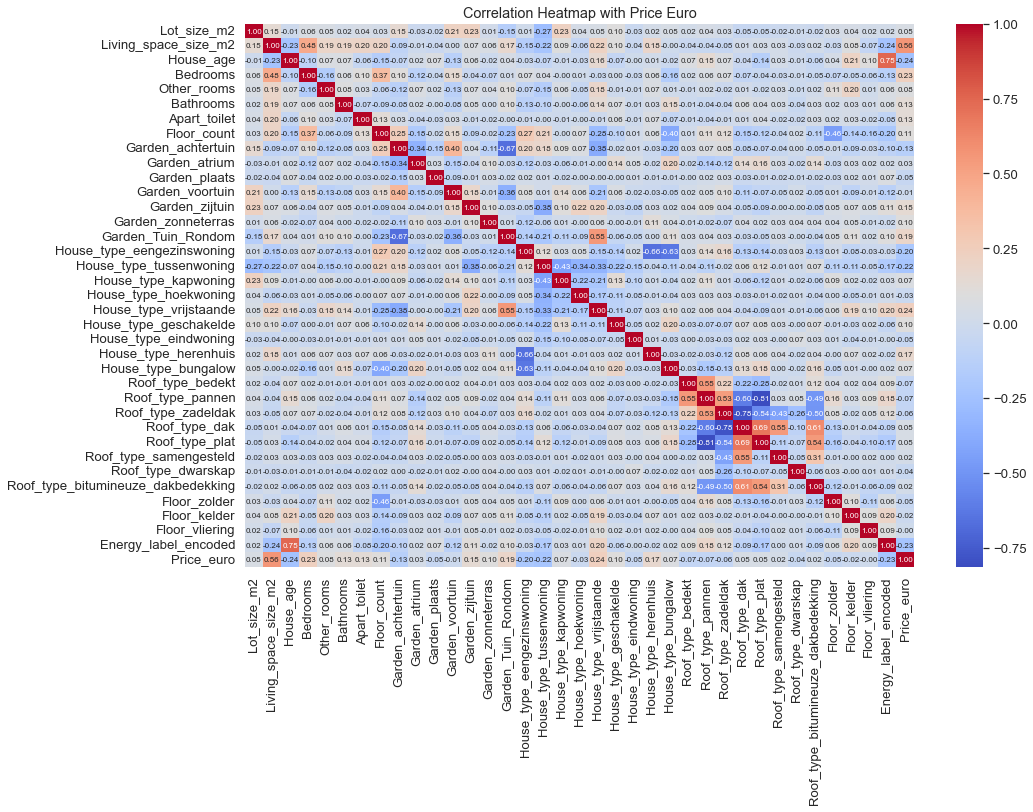

In [171]:
X_train_with_target_withoutgeo = X_train_without_geo.copy()
X_train_with_target_withoutgeo['Price_euro'] = y_train_without_geo

correlations_without_geo = X_train_with_target_withoutgeo.corr()

print(correlations_without_geo['Price_euro'].sort_values(ascending=False))

plt.figure(figsize=(15, 10))
sns.heatmap(correlations_without_geo, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap with Price Euro')
plt.show()

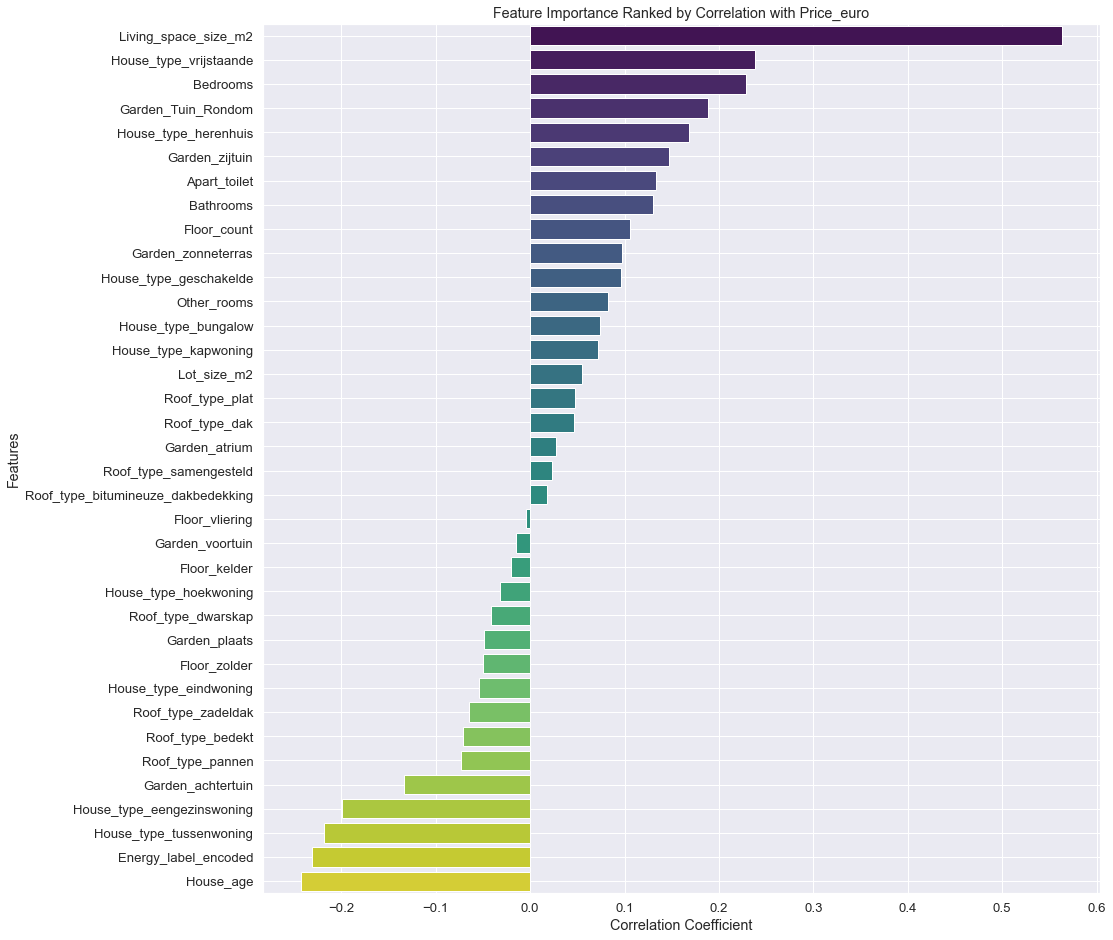

In [172]:
correlation_bar_withoutgeo2 = X_train_with_target_withoutgeo.corr()['Price_euro'].sort_values(ascending=False)

correlation_df_withoutgeo2 = pd.DataFrame(correlation_bar_withoutgeo2).reset_index()
correlation_df_withoutgeo2.columns = ['Feature', 'Correlation']

correlation_df_withoutgeo2 = correlation_df_withoutgeo2[correlation_df_withoutgeo2.Feature != 'Price_euro']

# Plotting
plt.figure(figsize=(15, 16)) 
sns.barplot(x='Correlation', y='Feature', data=correlation_df_withoutgeo2, palette="viridis")
plt.title('Feature Importance Ranked by Correlation with Price_euro')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [173]:
# Initialize the model without hyperparameter tuning
model_CatBoost_withoutgeo = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=False  
)


kf_catboost_withoutgeo = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_catboost_withoutgeo = []
mae_scores_catboost_withoutgeo = []
r2_scores_catboost_withoutgeo = []

# Perform K-Fold CV
for train_index_CatBoost_withoutgeo, val_index_CatBoost_withoutgeo in kf_catboost_withoutgeo.split(X_train_without_geo):
    X_train_fold_CatBoost_withoutgeo, X_val_fold_CatBoost_withoutgeo = X_train_without_geo.iloc[train_index_CatBoost_withoutgeo], X_train_without_geo.iloc[val_index_CatBoost_withoutgeo]
    y_train_fold_CatBoost_withoutgeo, y_val_fold_CatBoost_withoutgeo = y_train_without_geo.iloc[train_index_CatBoost_withoutgeo], y_train_without_geo.iloc[val_index_CatBoost_withoutgeo]

    model_CatBoost_withoutgeo.fit(X_train_fold_CatBoost_withoutgeo, y_train_fold_CatBoost_withoutgeo)

    y_pred_fold_CatBoost_withoutgeo = model_CatBoost_withoutgeo.predict(X_val_fold_CatBoost_withoutgeo)

    
y_test_pred_CatBoost_withoutgeo = model_CatBoost_withoutgeo.predict(X_test_without_geo)

# Calculate test metrics
test_rmse_CatBoost_withoutgeo = np.sqrt(mean_squared_error(y_test_without_geo, y_test_pred_CatBoost_withoutgeo))
test_mae_CatBoost_withoutgeo = mean_absolute_error(y_test_without_geo, y_test_pred_CatBoost_withoutgeo)
test_r2_CatBoost_withoutgeo = r2_score(y_test_without_geo, y_test_pred_CatBoost_withoutgeo)

# Print test scores
print("Test RMSE: ", test_rmse_CatBoost_withoutgeo)
print("Test MAE: ", test_mae_CatBoost_withoutgeo)
print("Test R²: ", test_r2_CatBoost_withoutgeo)

Test RMSE:  0.19607108032984624
Test MAE:  0.15439723967875657
Test R²:  0.4510590632346064


In [174]:
catboost_metrics = {
    'Model': [ 'CatBoost','CatBoost drop geo info' ],
    'RMSE': [ rmse_CatBoost_hyper, test_rmse_CatBoost_withoutgeo],
    'MAE': [ mae_CatBoost_hyper, test_mae_CatBoost_withoutgeo],
    'R2': [ r2_CatBoost_hyper,test_r2_CatBoost_withoutgeo]
}

catboost_metrics = pd.DataFrame(catboost_metrics)
print(catboost_metrics)

                    Model      RMSE       MAE        R2
0                CatBoost  0.150018  0.115103  0.650359
1  CatBoost drop geo info  0.196071  0.154397  0.451059


## 7.3 Among the evaluated models, which features are most significant in predicting housing prices in the best model?

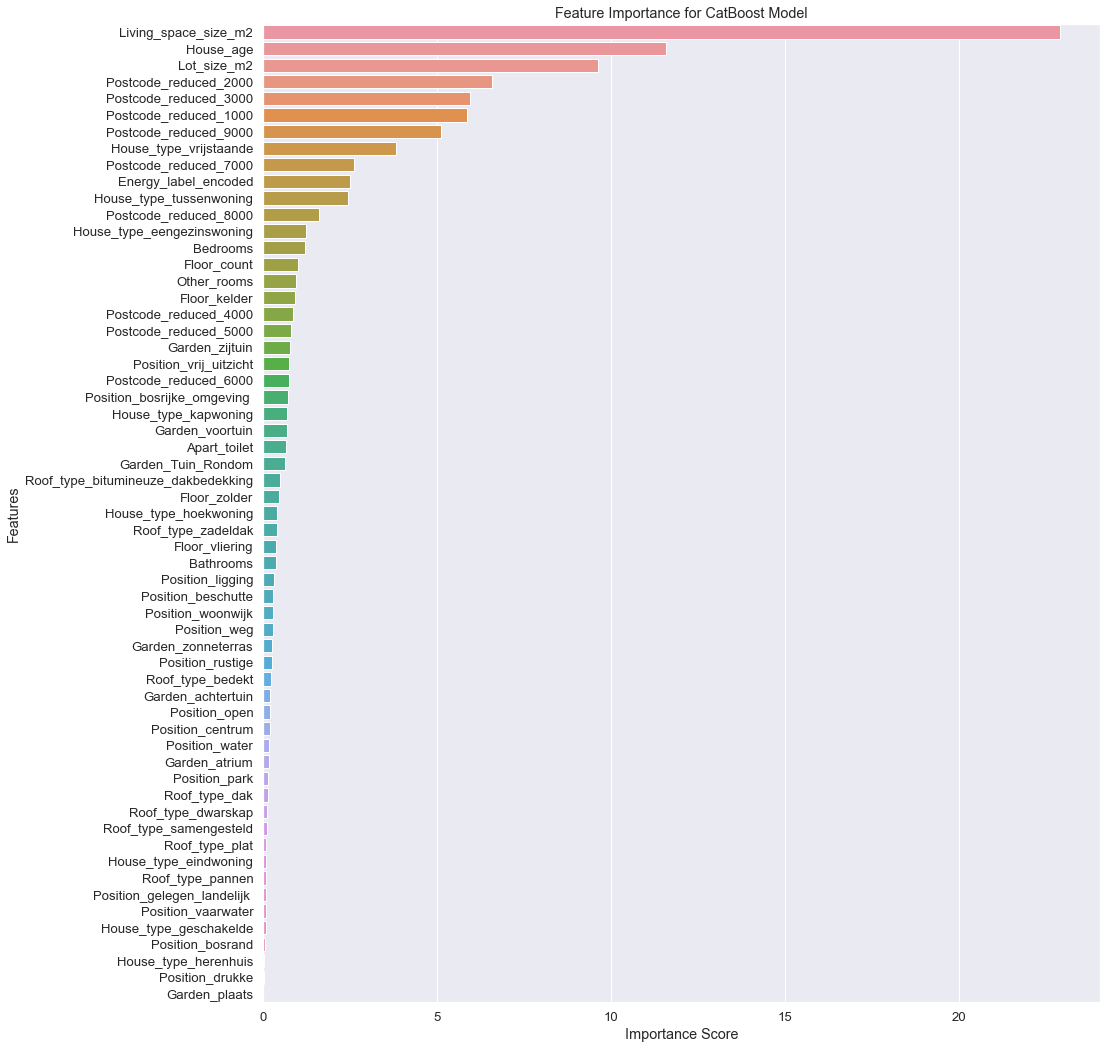

Top feature importances CatBoost:
 Living_space_size_m2                  22.909488
House_age                             11.584719
Lot_size_m2                            9.618717
Postcode_reduced_2000                  6.573228
Postcode_reduced_3000                  5.945182
Postcode_reduced_1000                  5.878132
Postcode_reduced_9000                  5.107025
House_type_vrijstaande                 3.815784
Postcode_reduced_7000                  2.609417
Energy_label_encoded                   2.494854
House_type_tussenwoning                2.439819
Postcode_reduced_8000                  1.622835
House_type_eengezinswoning             1.254010
Bedrooms                               1.201868
Floor_count                            1.016163
Other_rooms                            0.951430
Floor_kelder                           0.920541
Postcode_reduced_4000                  0.853326
Postcode_reduced_5000                  0.798282
Garden_zijtuin                         0.786222
Posit

In [175]:
feature_importances_cb = best_model_CatBoost.feature_importances_

if len(feature_importances_cb) == X_train.shape[1]:
    feature_importances_series_cb = pd.Series(feature_importances_cb, index=X_train.columns)

    sorted_feature_importances_cb = feature_importances_series_cb.sort_values(ascending=False)
    top_features_cb = sorted_feature_importances_cb.head(100)

    plt.figure(figsize=(15, 18))
    sns.barplot(x=top_features_cb.values, y=top_features_cb.index)
    plt.title('Feature Importance for CatBoost Model')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

    print("Top feature importances CatBoost:\n", top_features_cb)
else:
    print(f"Error: The number of feature importances ({len(feature_importances_cb)}) does not match the number of columns in X_train ({X_train.shape[1]}).")
